# Plots for VTS1 analysis

In [1]:
import os
import numpy as np
import pandas as pd
import logomaker
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

from residualbind import ResidualBind
import helper, explain

Using TensorFlow backend.


In [2]:

data_path = '../data/RNAcompete_2009/rnacompete2009.h5'
results_path = os.path.join('../results_final2', 'rnacompete_2009')

normalization = 'log_norm'   # 'log_norm' or 'clip_norm'
ss_type = 'seq'                  # 'seq', 'pu', or 'struct'
save_path = os.path.join(results_path, normalization+'_'+ss_type)
plot_path = helper.make_directory(save_path, 'FINAL2')

In [3]:
rbp_name = 'VTS1'
normalization = 'log_norm'   # 'log_norm' or 'clip_norm'
ss_type = 'seq'                  # 'seq', 'pu', or 'struct'
save_path = os.path.join(results_path, normalization+'_'+ss_type)

# load rbp dataset
train, valid, test = helper.load_rnacompete_data(data_path, 
                                                 ss_type=ss_type, 
                                                 normalization=normalization, 
                                                 dataset_name=rbp_name)

# load residualbind model
input_shape = list(train['inputs'].shape)[1:]
weights_path = os.path.join(save_path, rbp_name + '_weights.hdf5')    
model = ResidualBind(input_shape, weights_path)

# load pretrained weights
model.load_weights()

# get predictions for test sequences
predictions = model.predict(test['inputs'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  Loading model from: ../results_final2/rnacompete_2009/log_norm_seq/VTS1_weights.hdf5


In [4]:
# motif scan test sequences
motif = 'GCUGG'
M = len(motif)
motif_onehot = np.zeros((M, 4))
for i, m in enumerate(motif):
    motif_onehot[i, "ACGU".index(m)] = 1

max_scan = []
for x in test['inputs']:
    scan = []
    for l in range(39-M):
        scan.append(np.sum(x[range(l,l+M),:]*motif_onehot))
    max_scan.append(np.max(scan))
    
high_index = np.where((predictions[:,0] > 3.5) & (test['targets'][:,0] > 3.5) & (predictions[:,0] < 5))[0]
print(len(high_index))

low_index = np.where((np.array(max_scan) == 5) & (predictions[:,0] > 0) & (test['targets'][:,0] > 0) & (predictions[:,0] < 1)& (test['targets'][:,0] < 1))[0]
print(len(low_index))

77
531


# Select regions to investigate

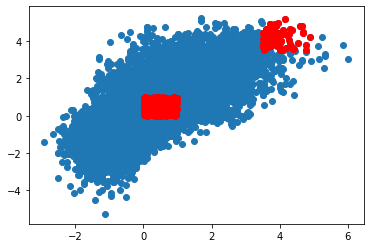

In [8]:
plt.scatter(predictions[:,0], test['targets'][:,0])#, c=max_scan, cmap='viridis', alpha=0.5)

#index = [1305,48565,105952]
plt.scatter(predictions[high_index,0], test['targets'][high_index,0], c='r')
plt.scatter(predictions[low_index,0], test['targets'][low_index,0], c='r')

# Generate mutagenesis maps

In [24]:
rbp_name = 'VTS1'
normalization = 'log_norm'   # 'log_norm' or 'clip_norm'
save_path = helper.make_directory(results_path, normalization+'_'+ss_type)

# load rbp dataset
train, valid, test = helper.load_rnacompete_data(data_path, 
                                                 ss_type='seq', 
                                                 normalization=normalization, 
                                                 dataset_name=rbp_name)
# load rbp dataset
train_pu, valid_pu, test_pu = helper.load_rnacompete_data(data_path, 
                                                         ss_type='pu', 
                                                         normalization=normalization, 
                                                         dataset_name=rbp_name)

# load residualbind model
input_shape = list(train['inputs'].shape)[1:]
weights_path = os.path.join(save_path, rbp_name + '_weights.hdf5')    
model = ResidualBind(input_shape, weights_path)

# load pretrained weights
model.load_weights()

X_high = test_pu['inputs'][high_index]
attr_map_high = explain.mutagenesis(model.model, X_high[:,:,:4], class_index=0, layer=-1)
attr_map_high = np.sum(attr_map_high[:,:,:4]**2, axis=2, keepdims=True)*X_high[:,:,:4]

X_low = test_pu['inputs'][low_index[:75]]
attr_map_low = explain.mutagenesis(model.model, X_low[:,:,:4], class_index=0, layer=-1)
attr_map_low = np.sum(attr_map_low[:,:,:4]**2, axis=2, keepdims=True)*X_low[:,:,:4]


  Loading model from: ../results_final/rnacompete_2009/log_norm_seq/VTS1_weights.hdf5


# plot mutagenesis maps for low binding scores

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


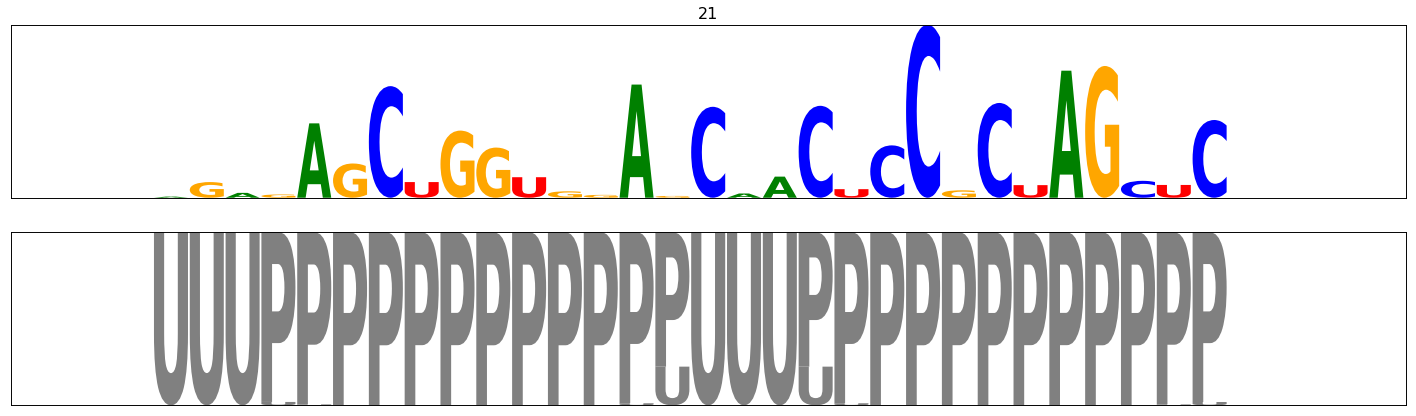

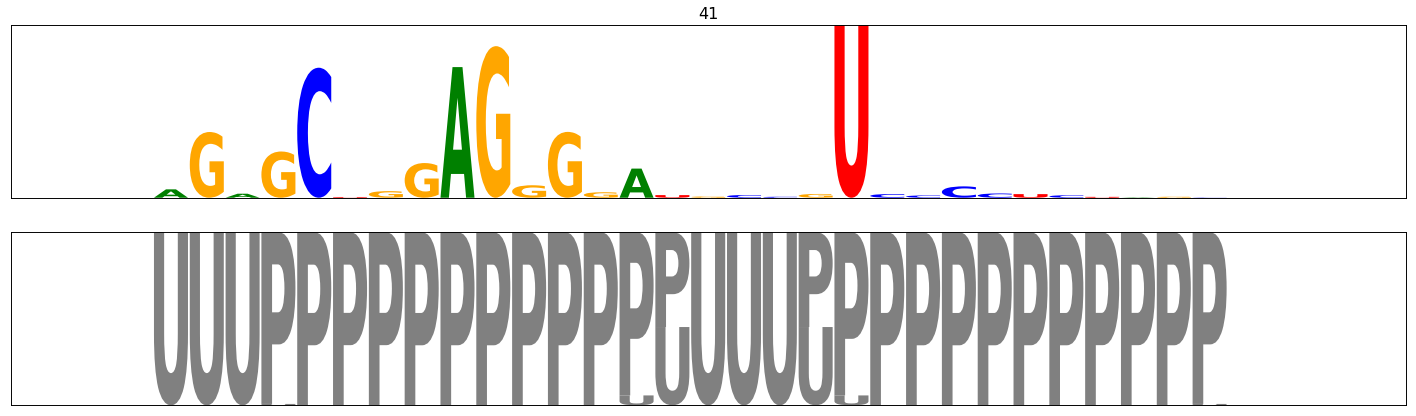

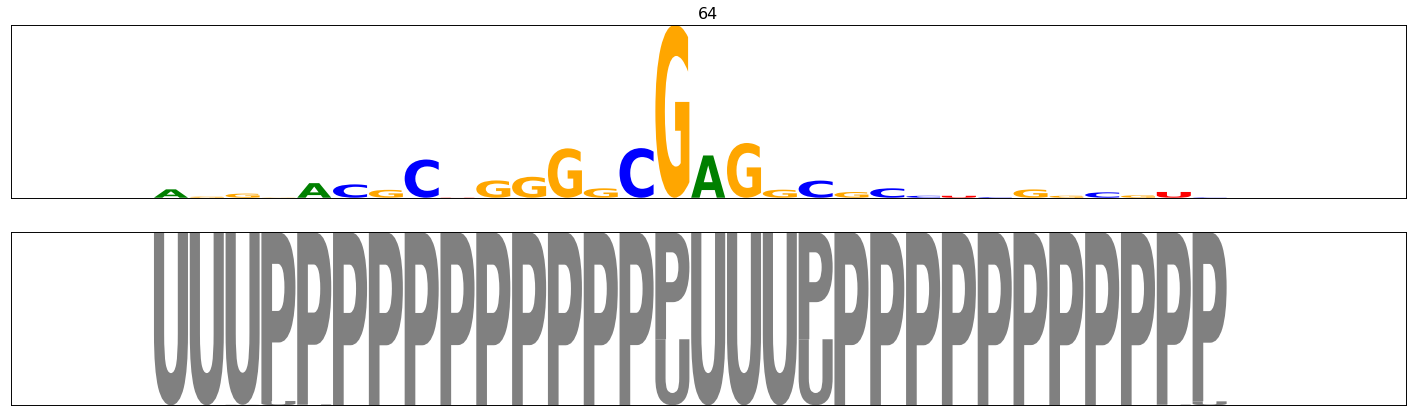

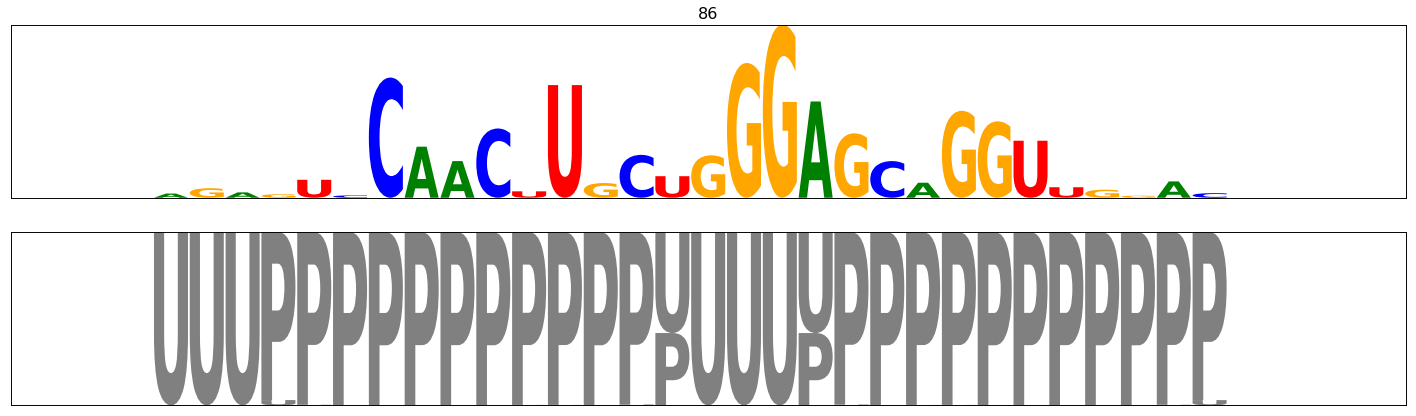

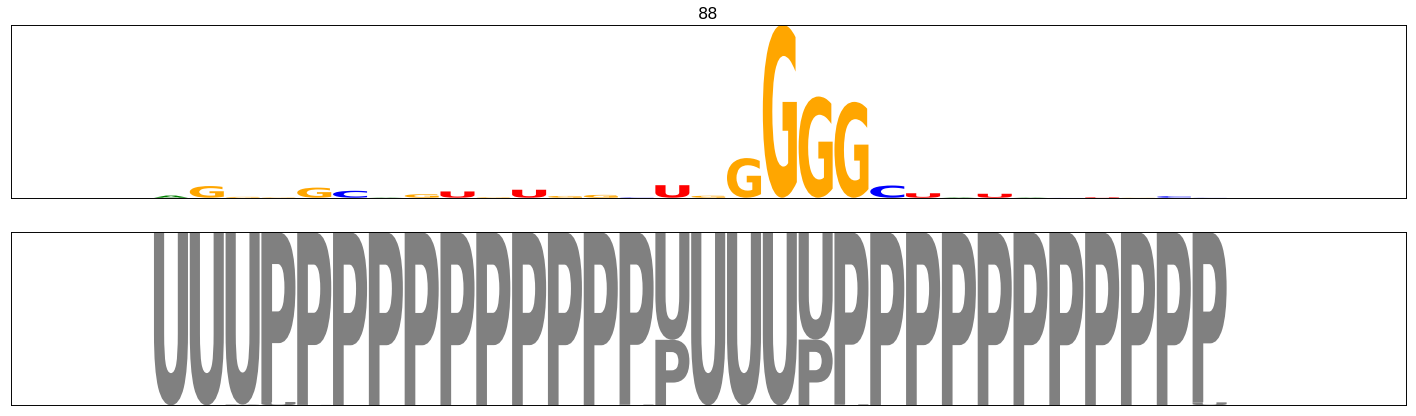

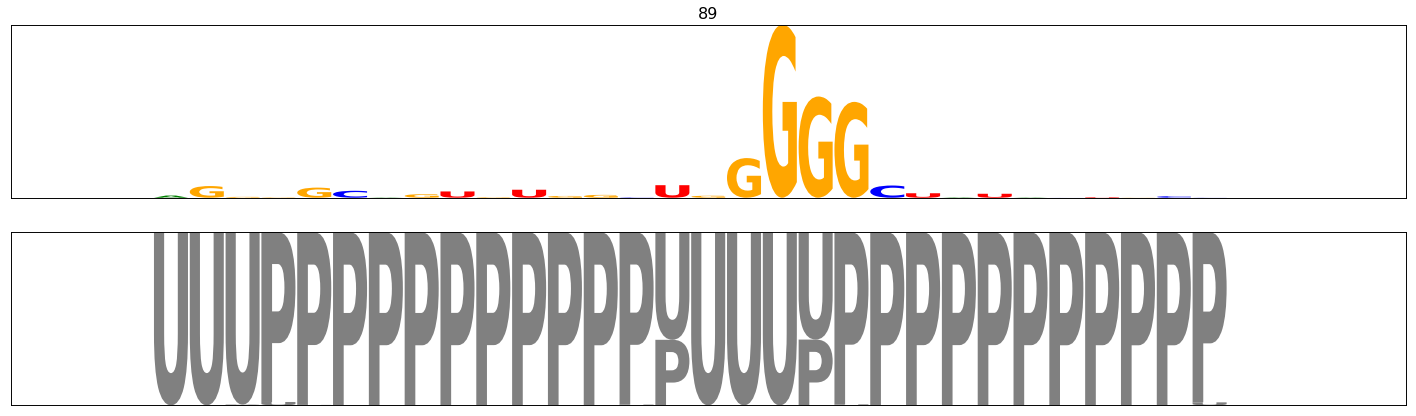

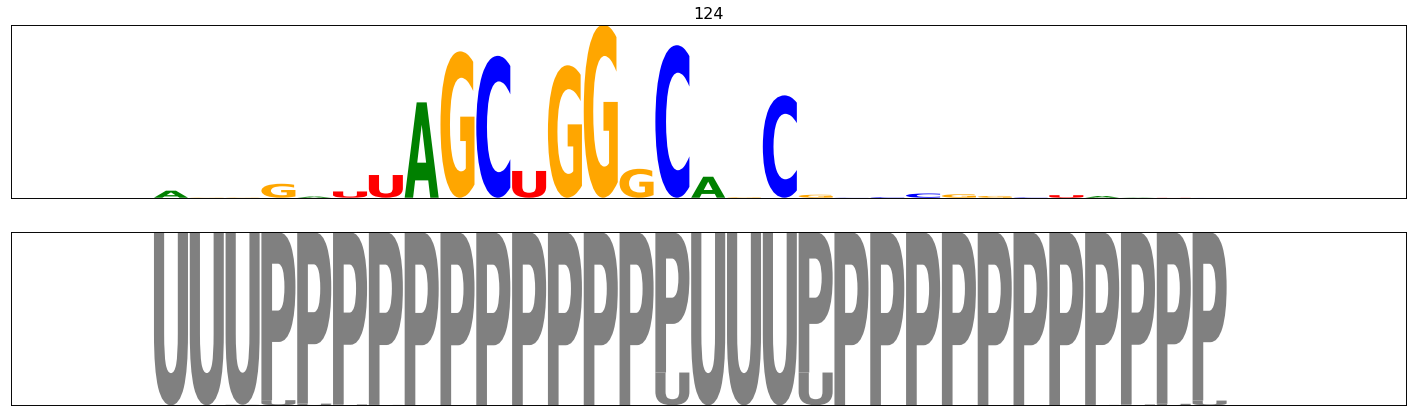

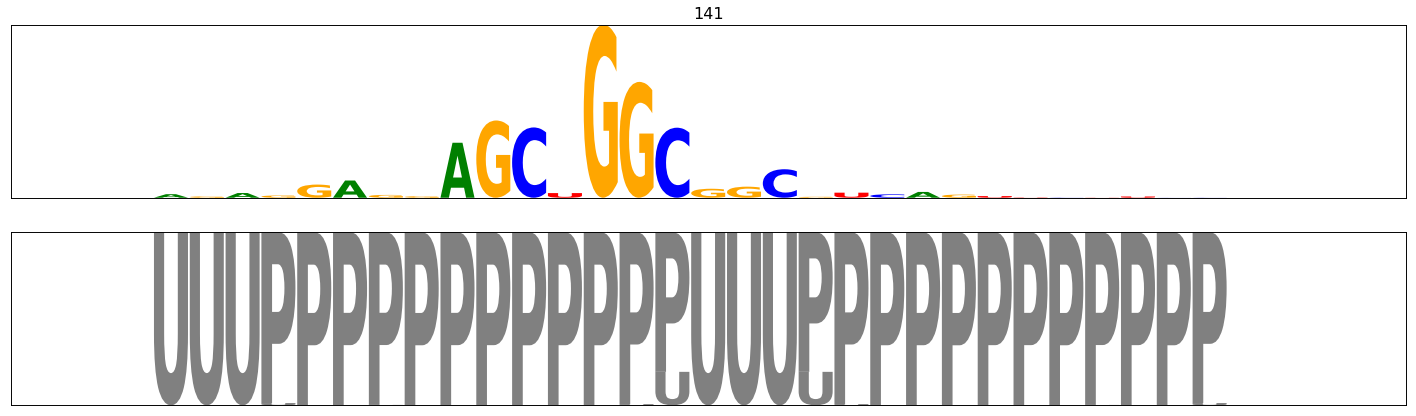

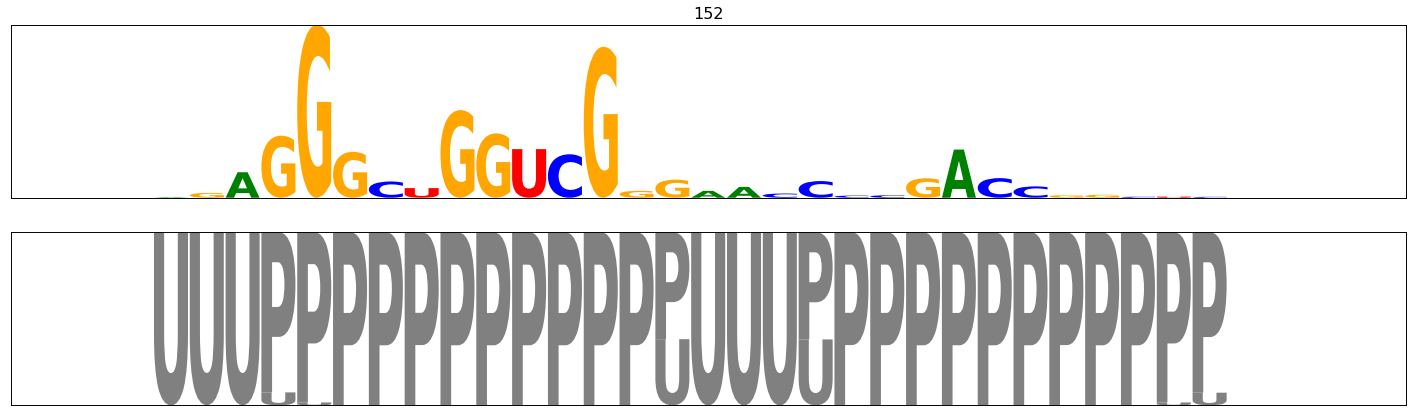

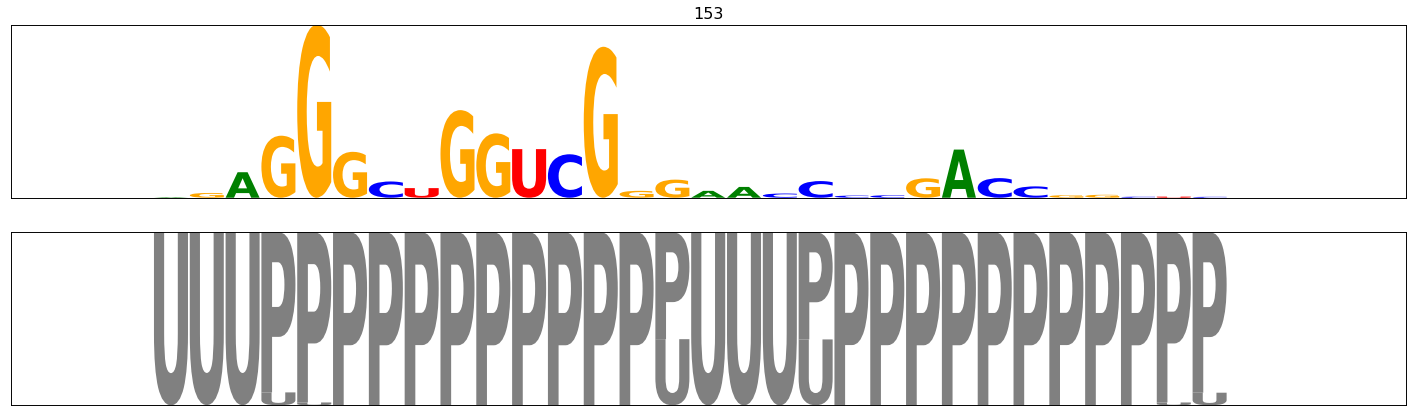

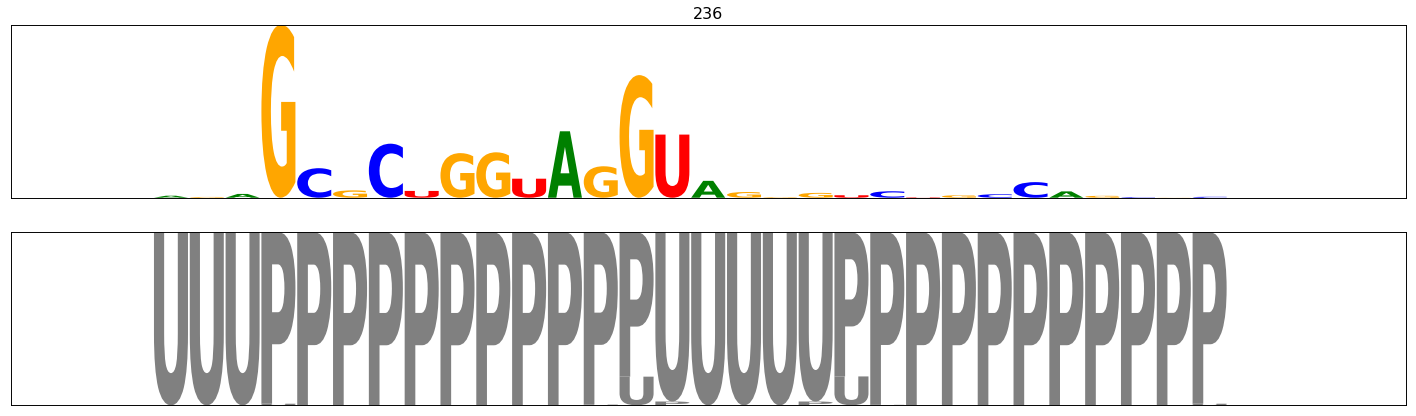

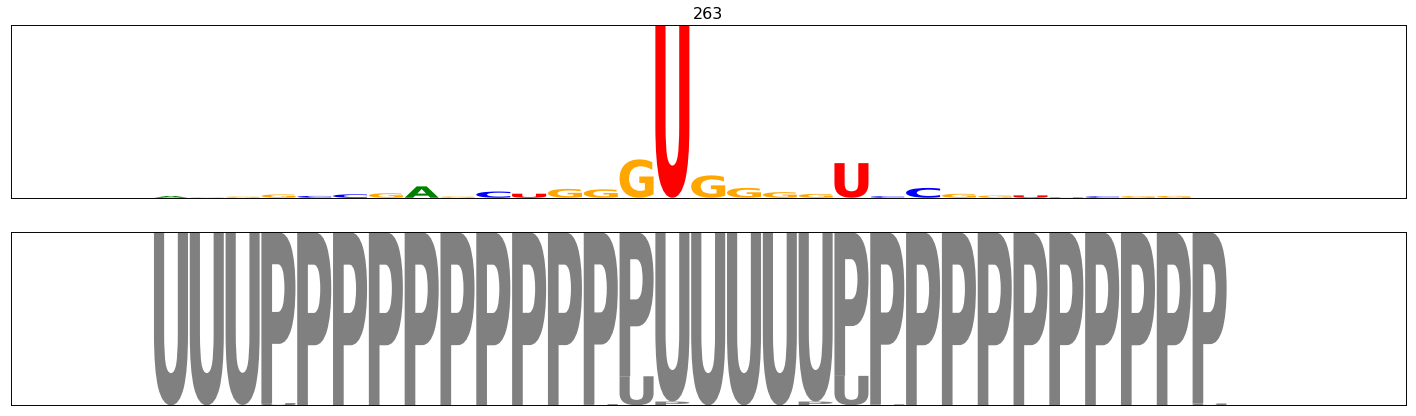

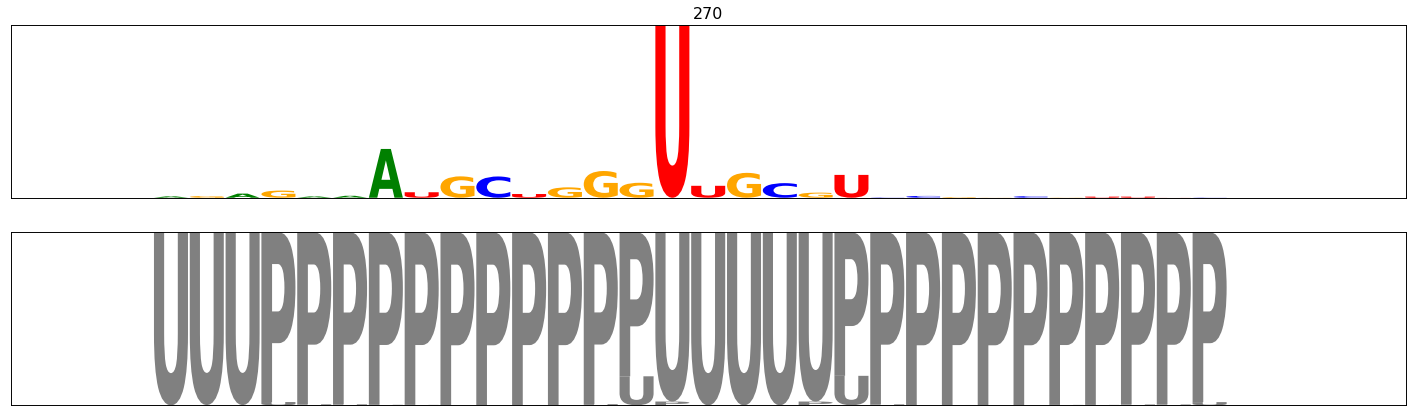

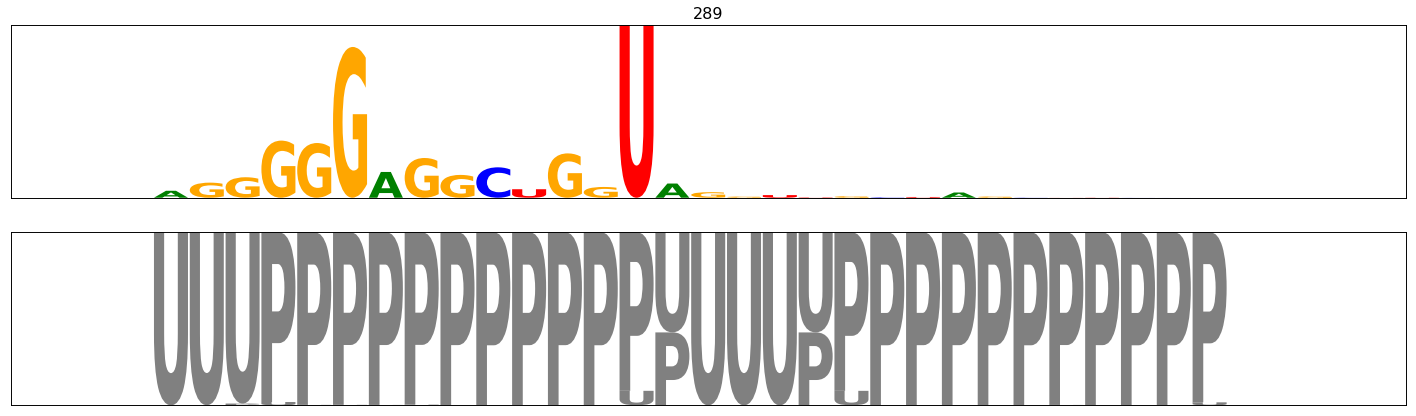

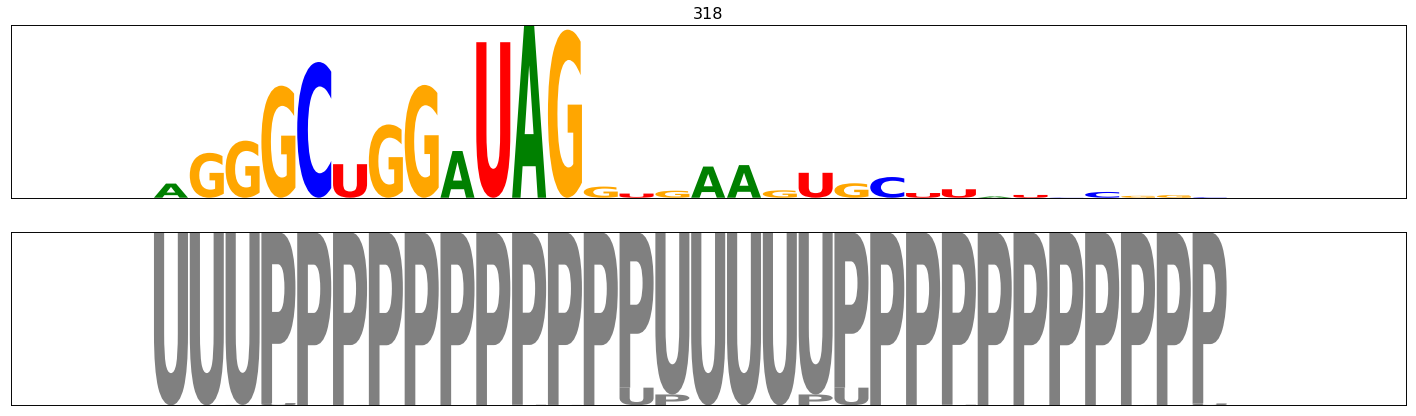

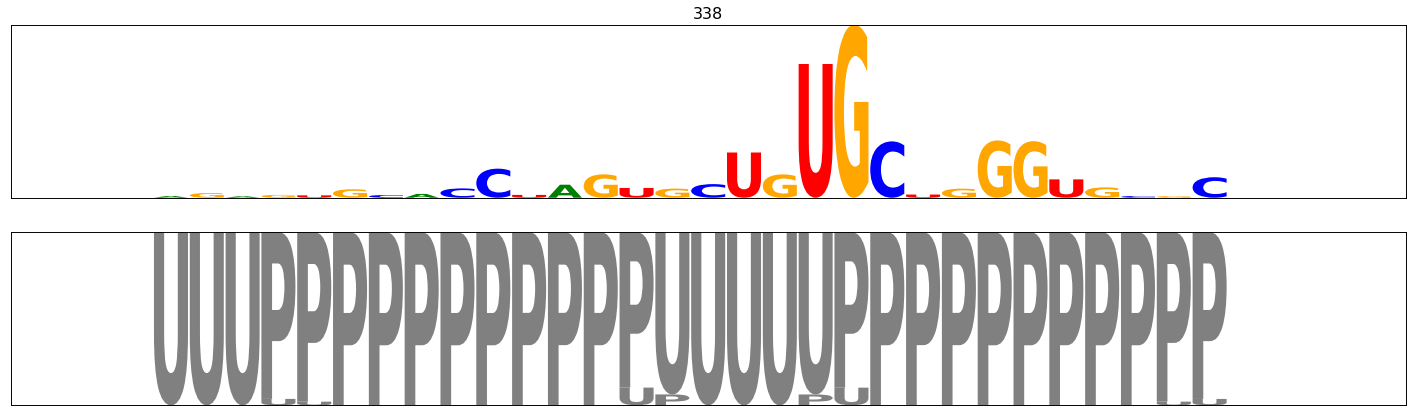

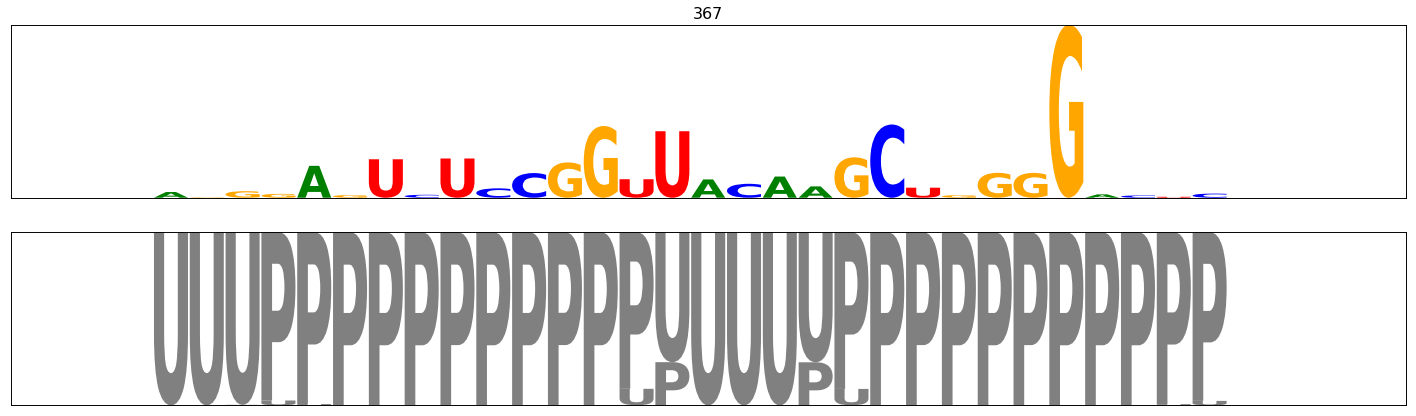

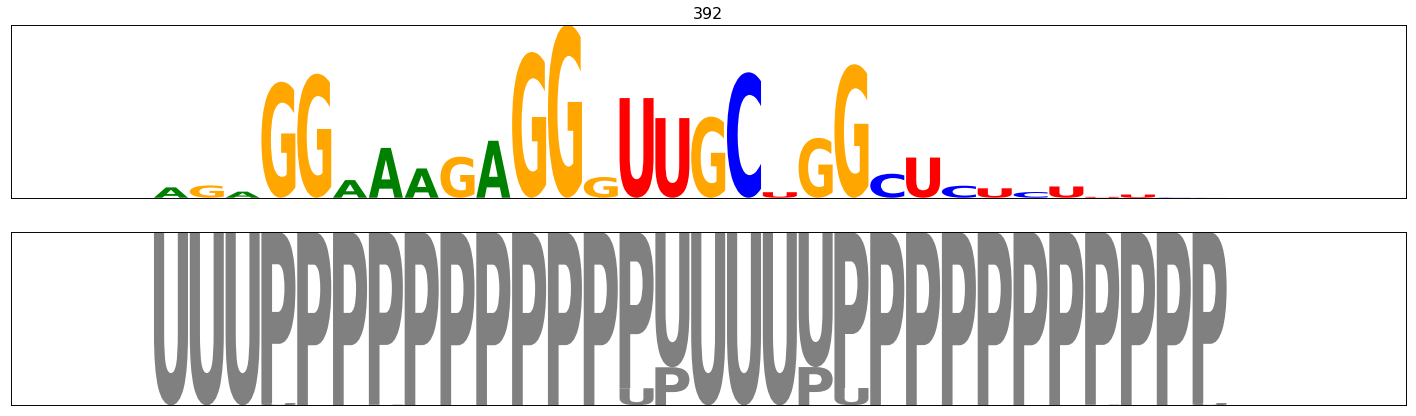

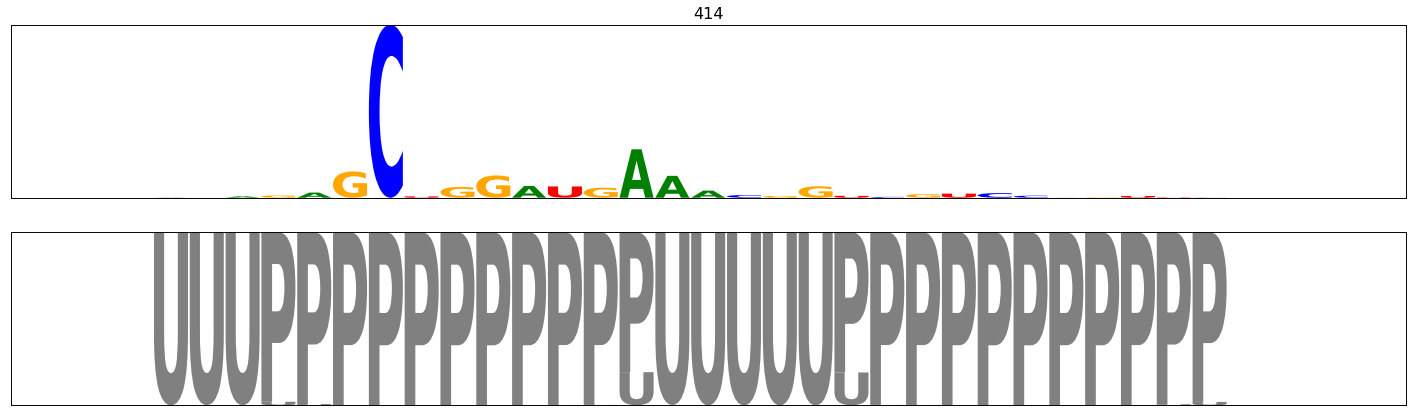

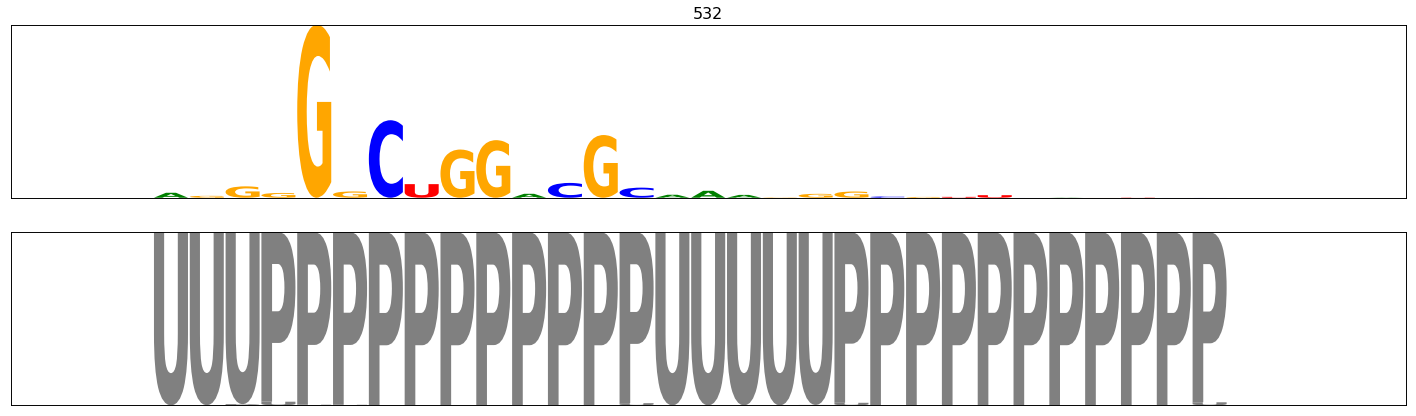

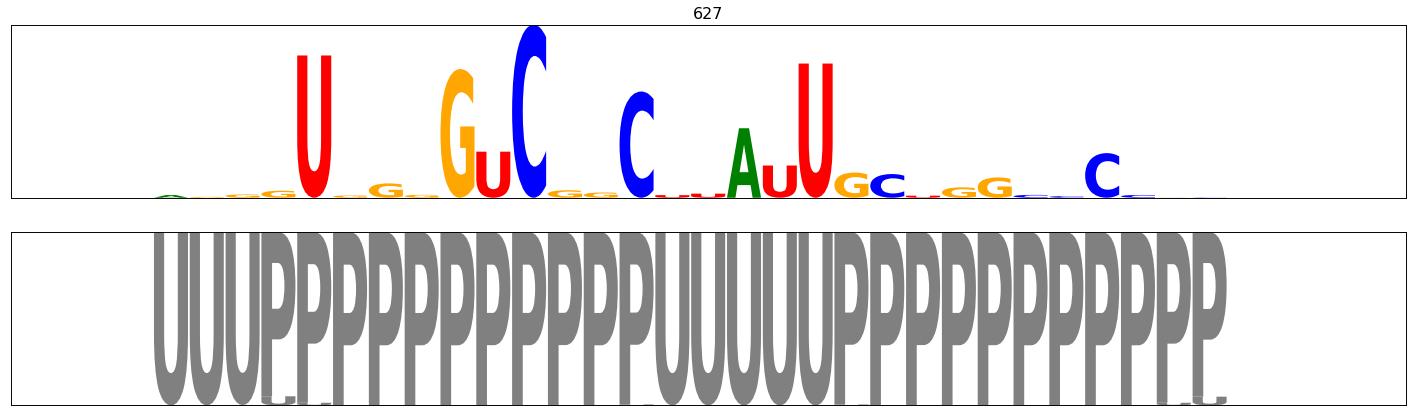

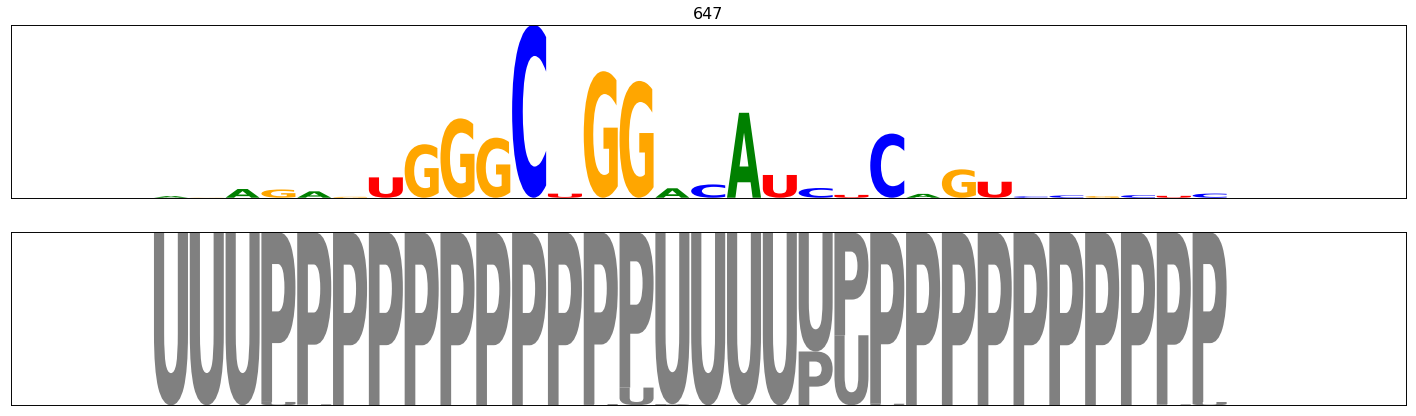

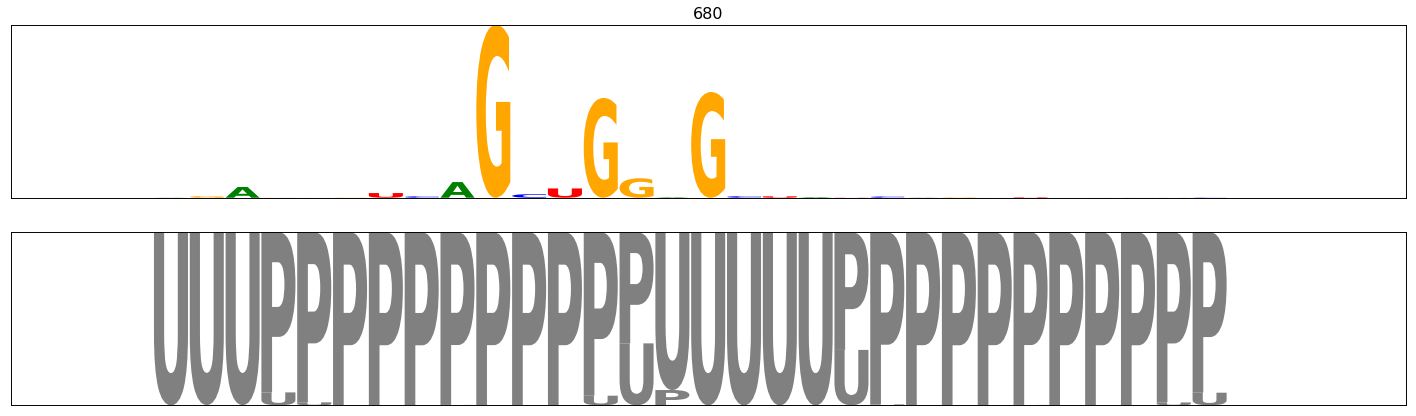

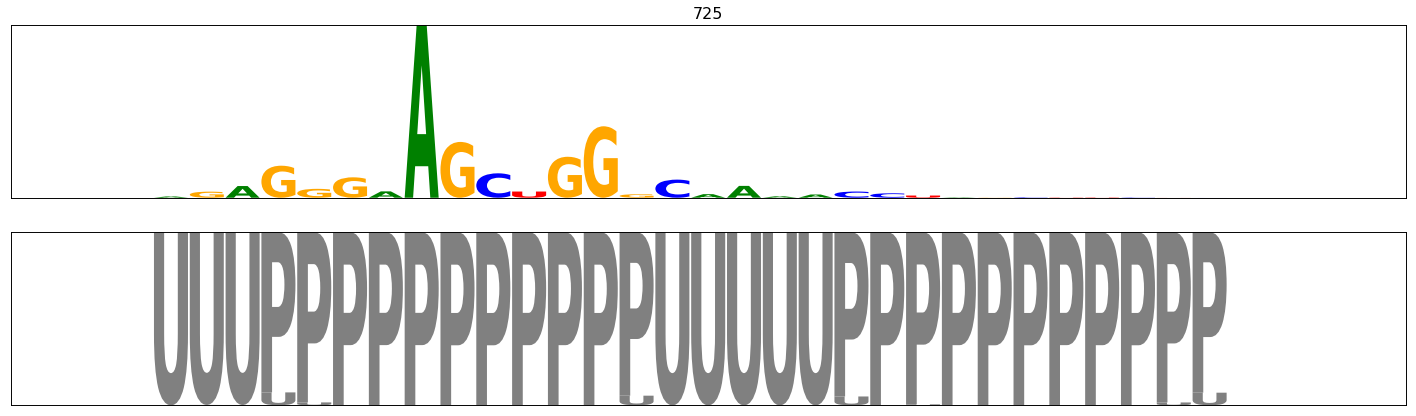

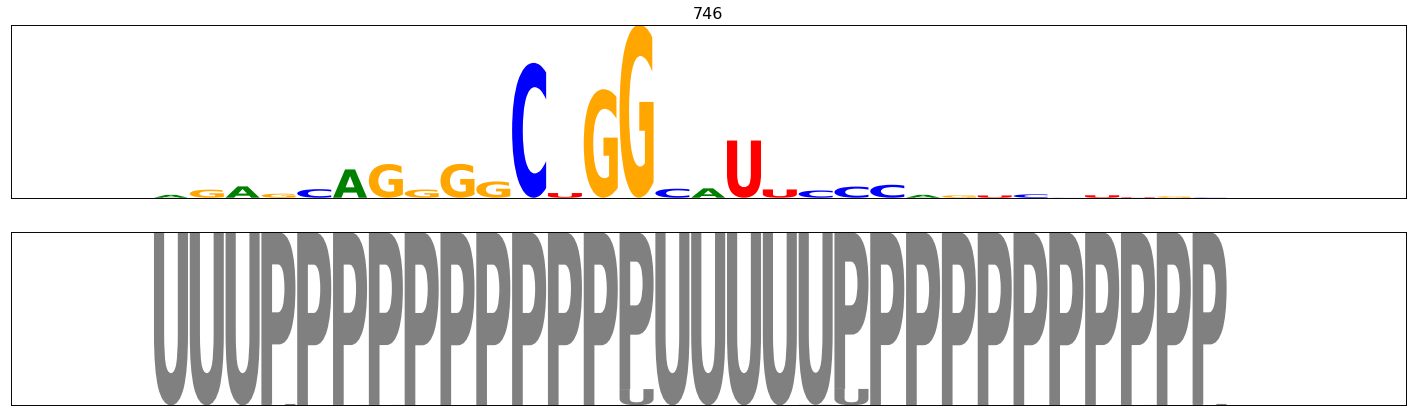

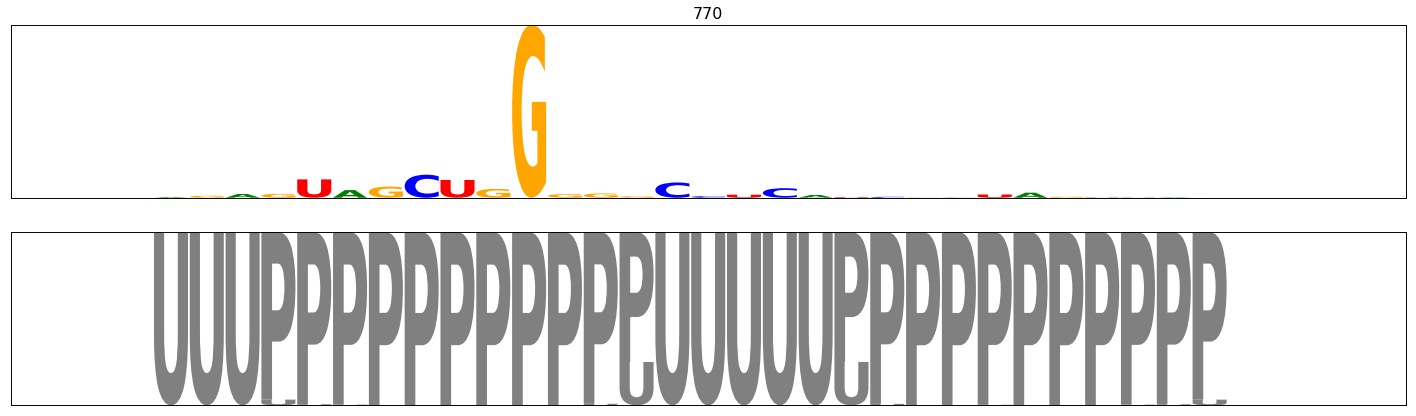

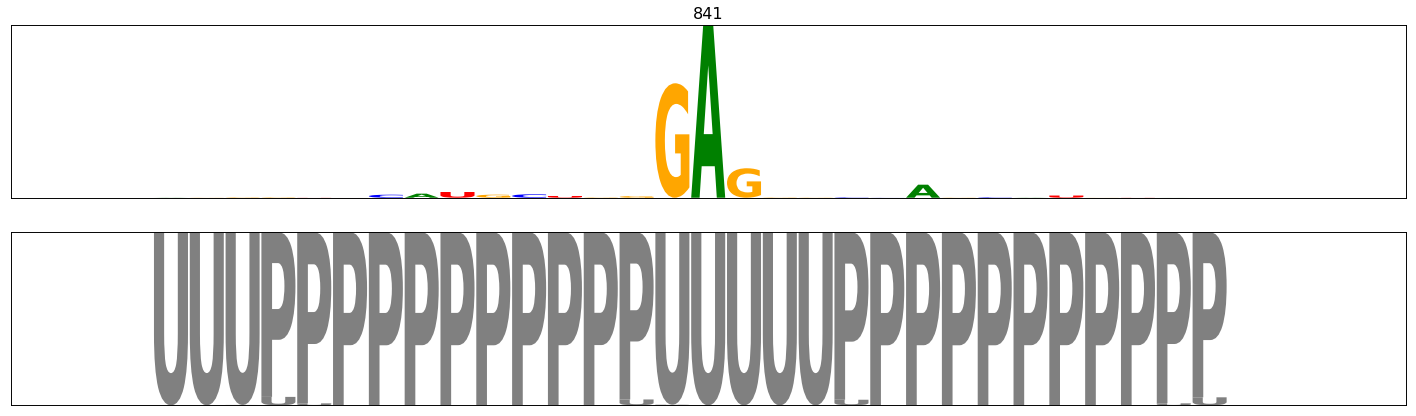

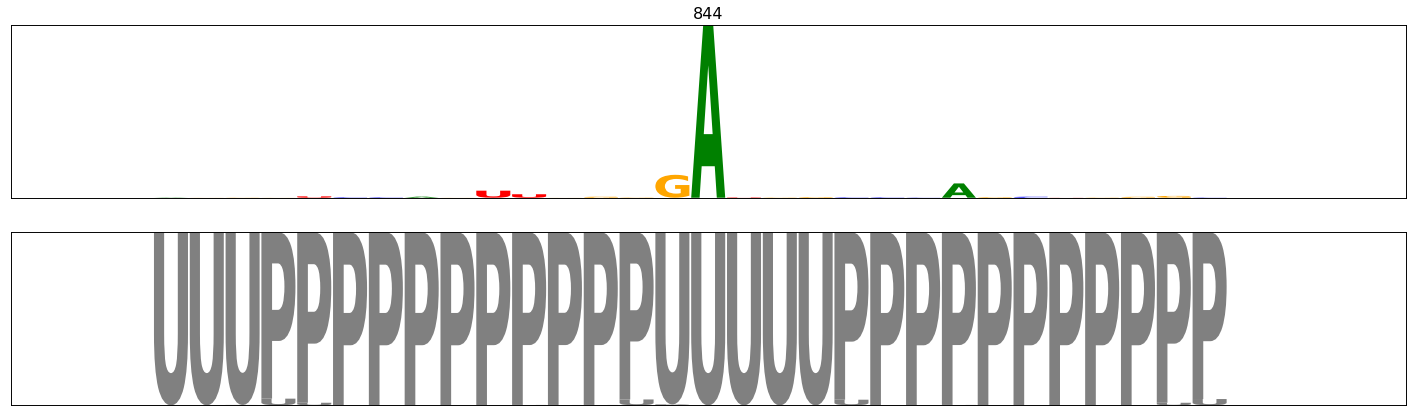

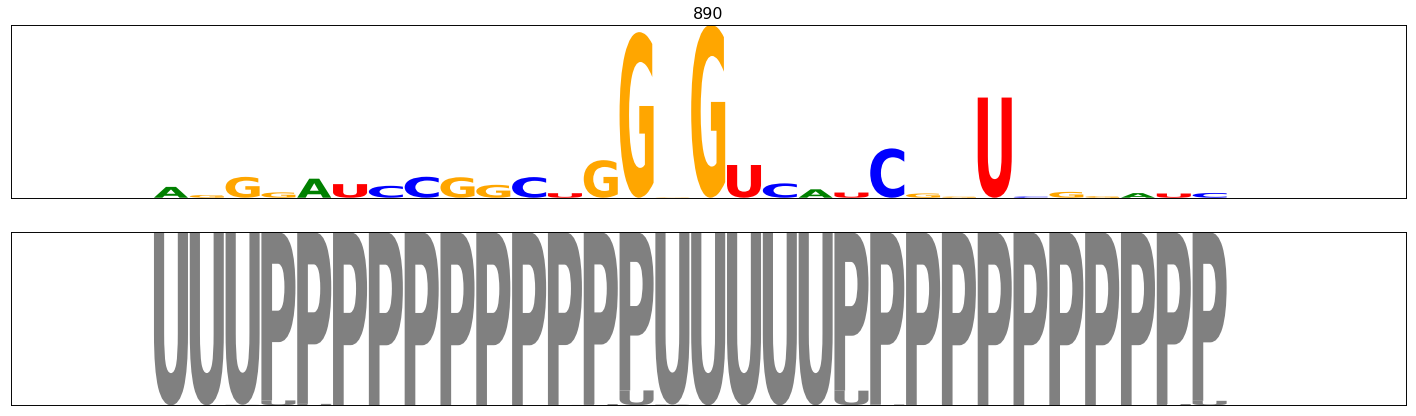

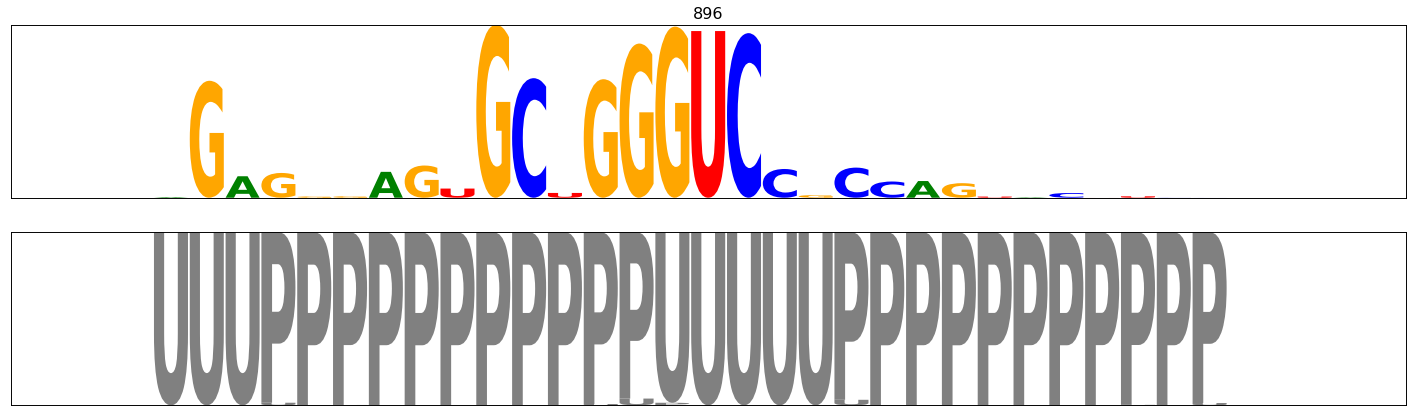

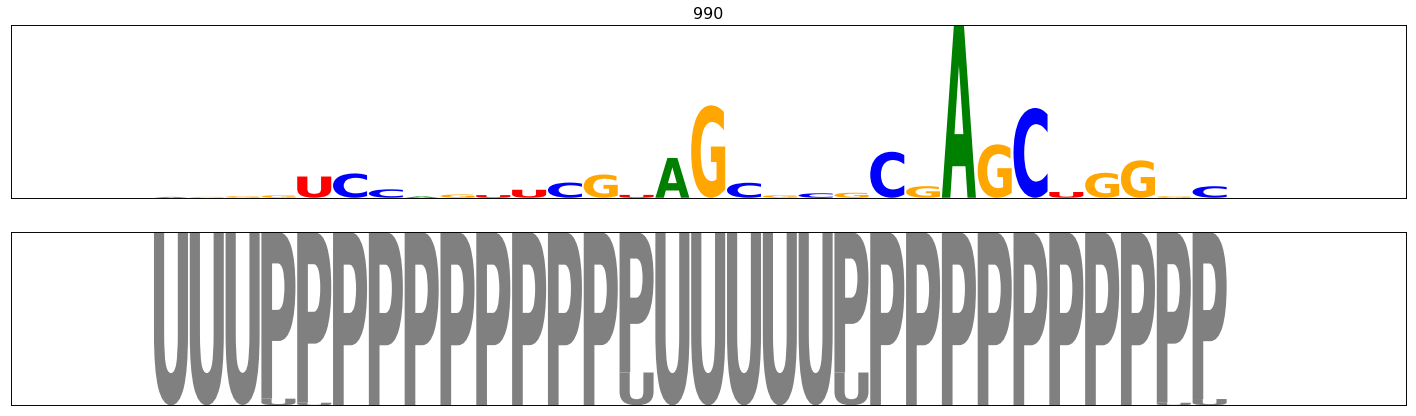

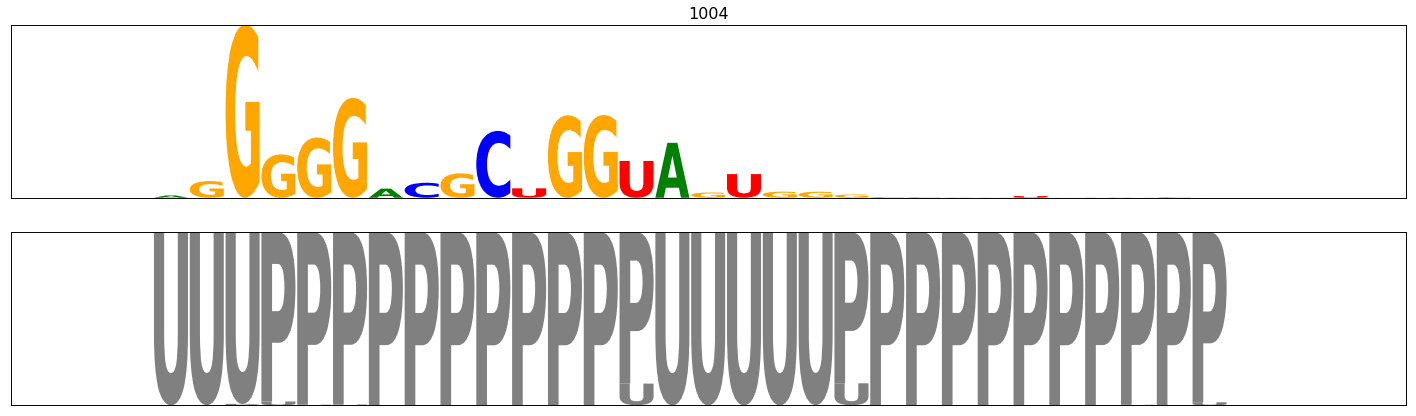

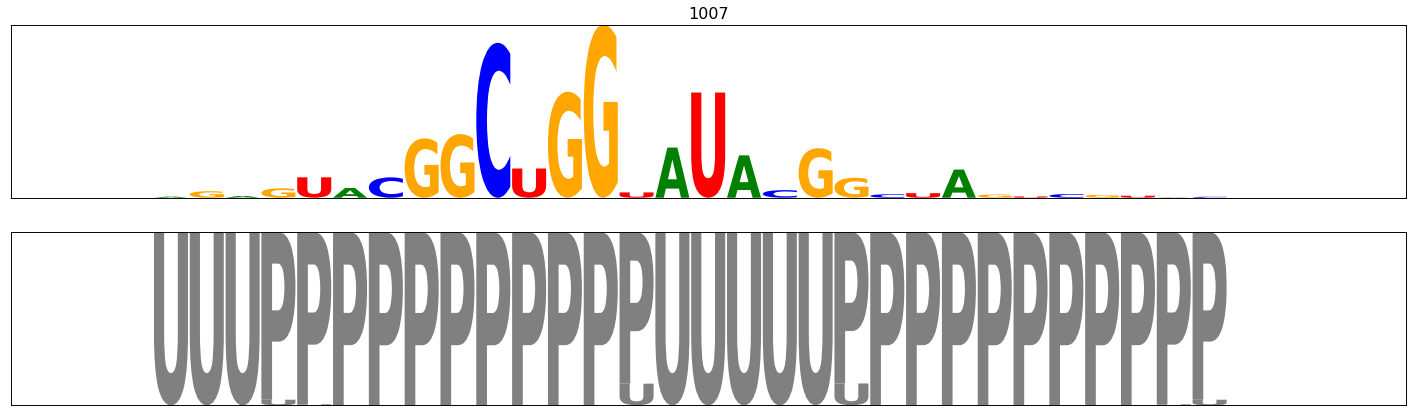

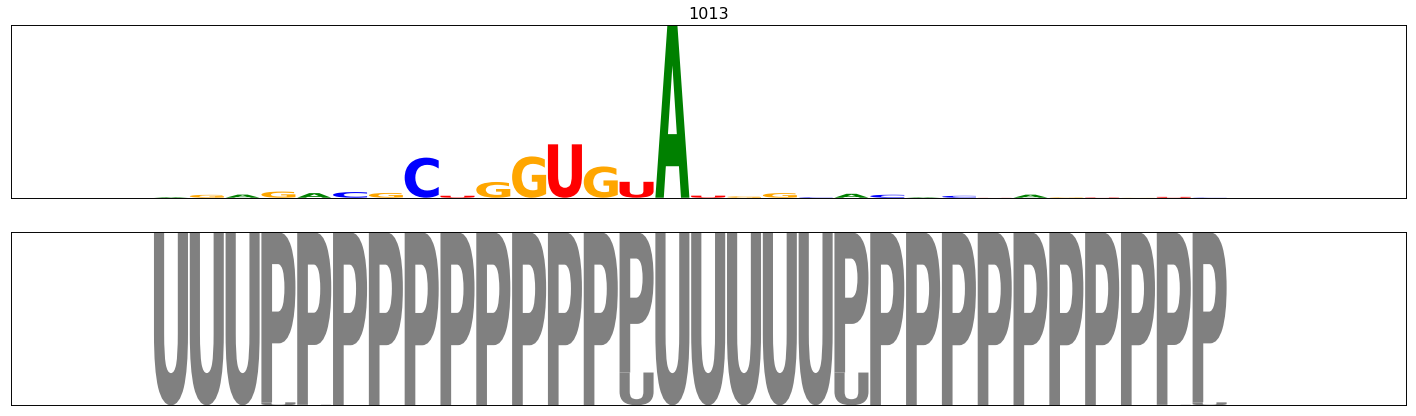

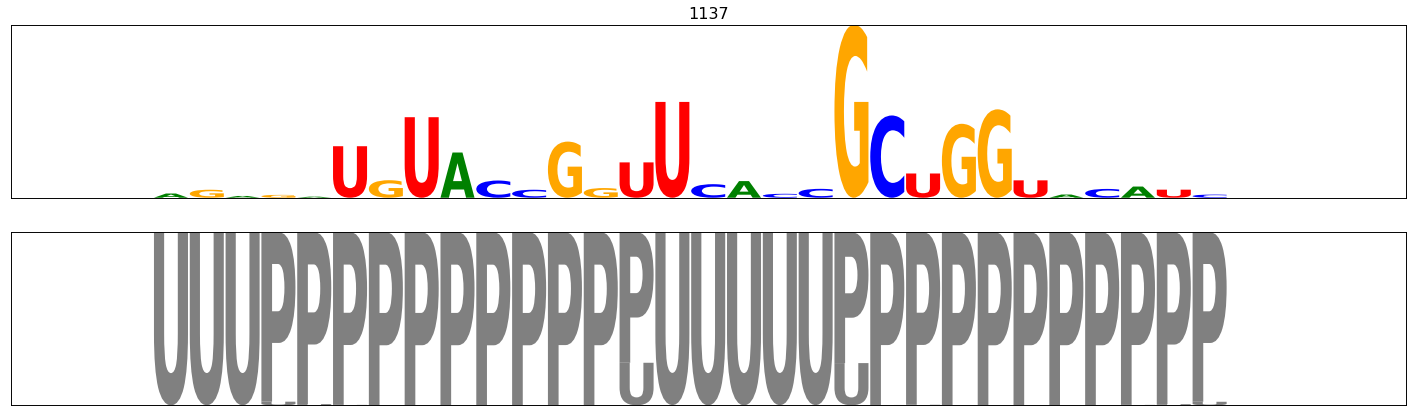

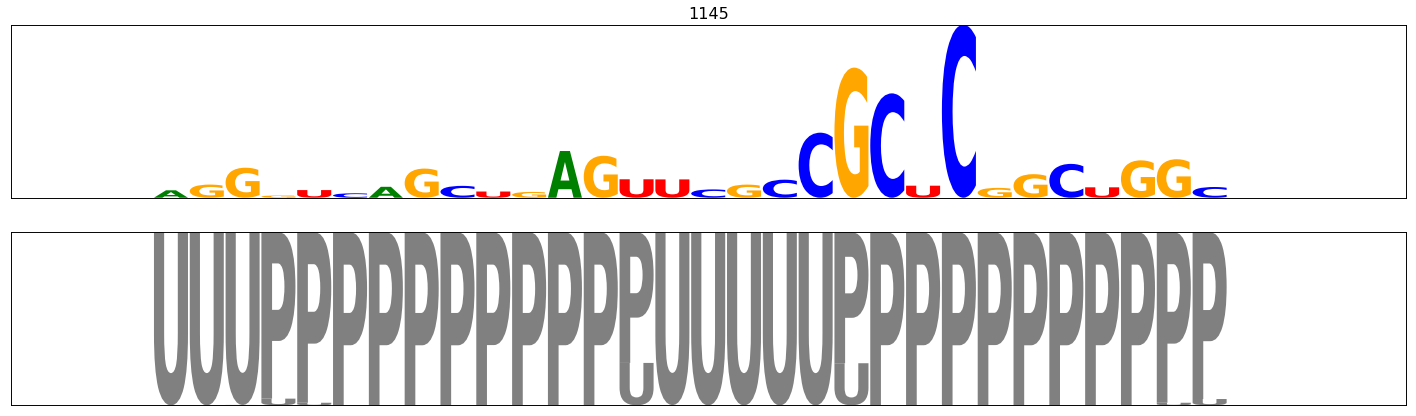

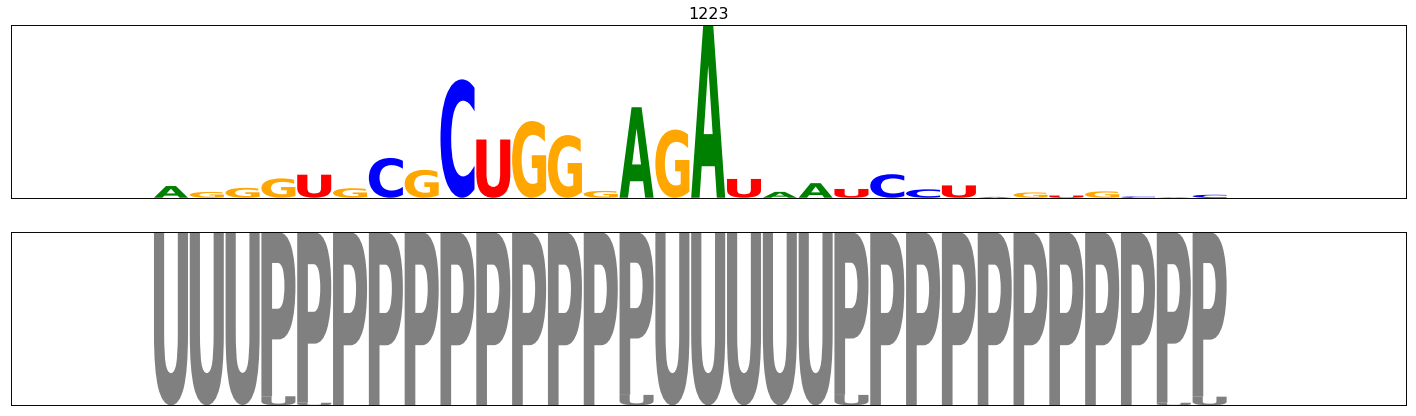

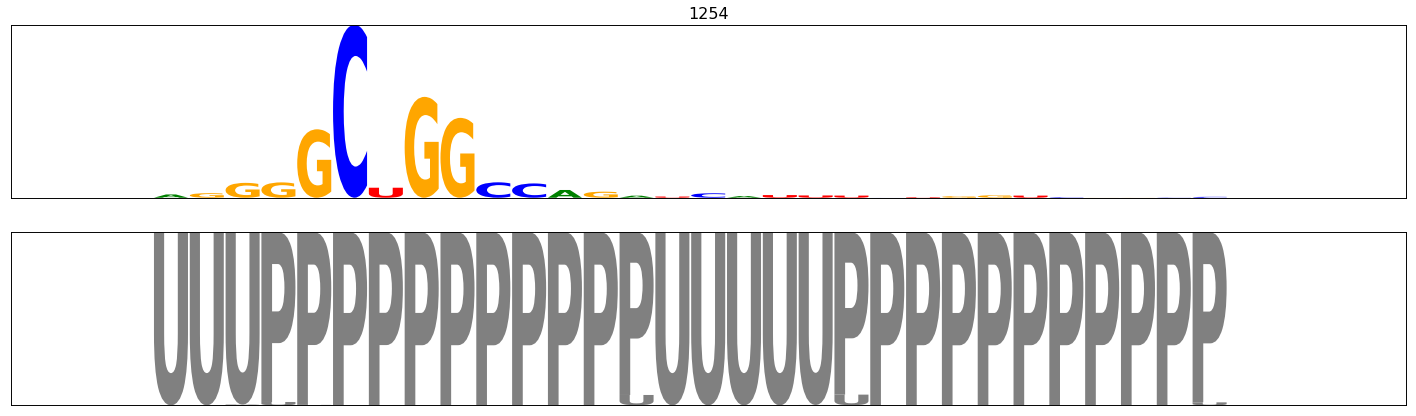

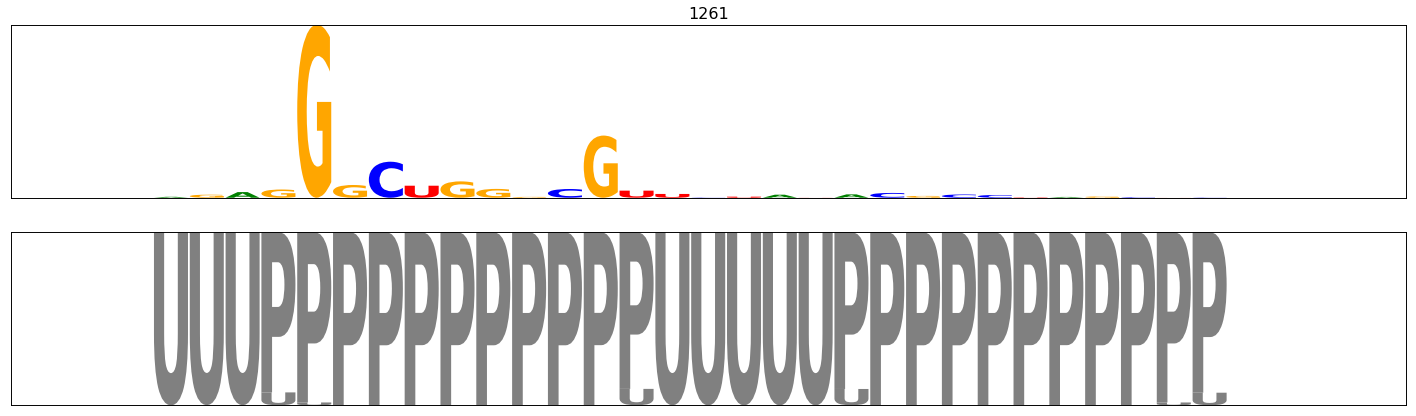

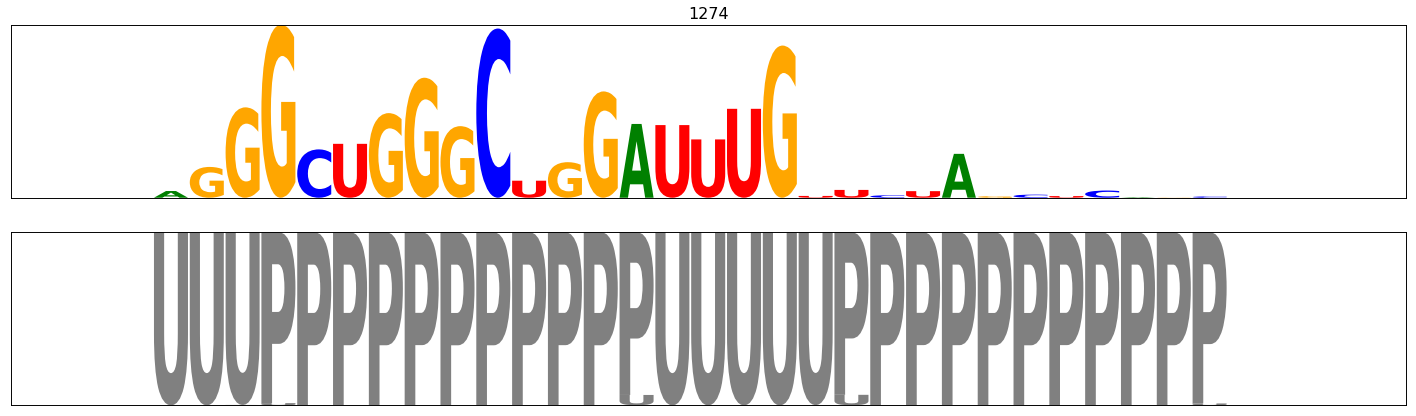

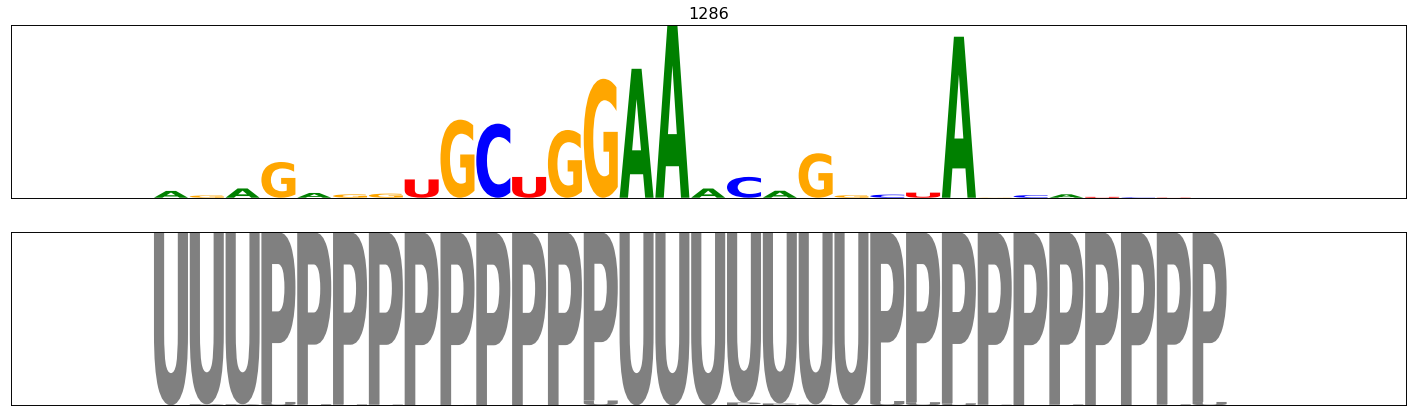

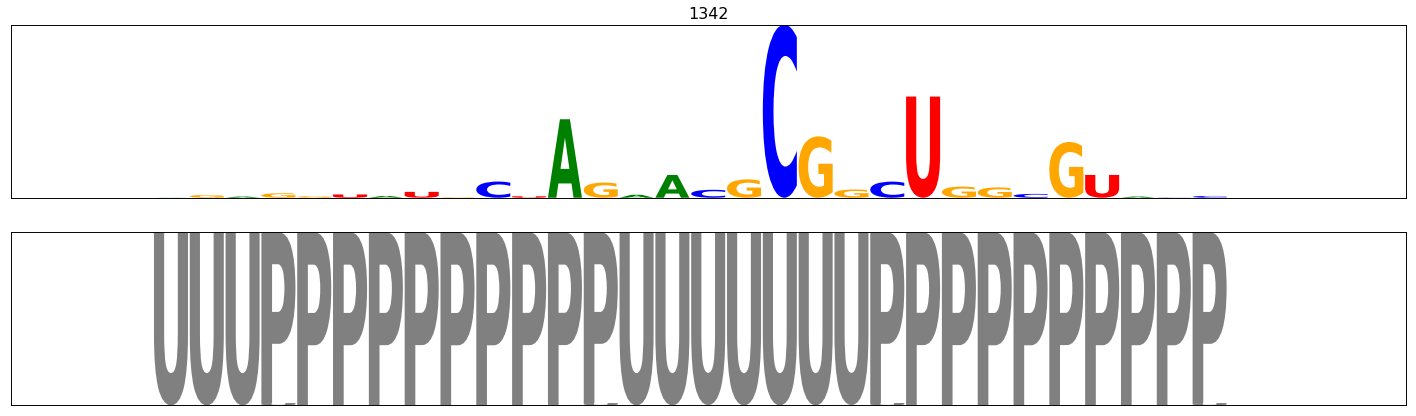

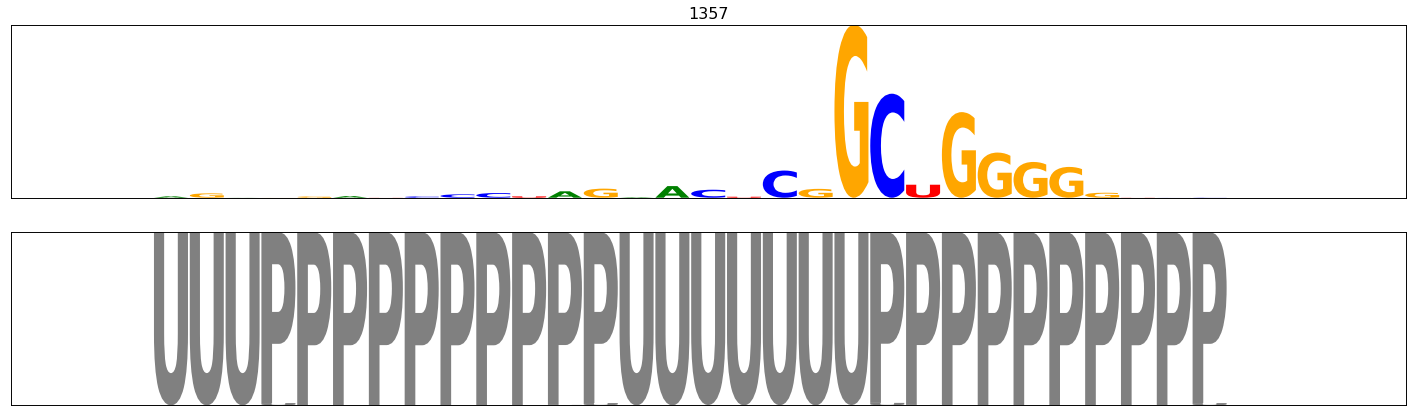

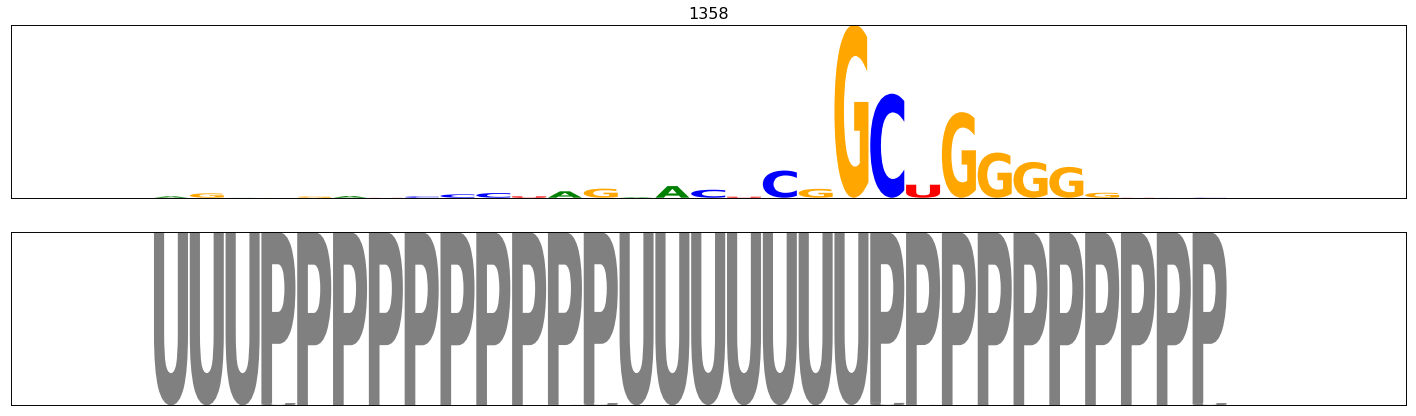

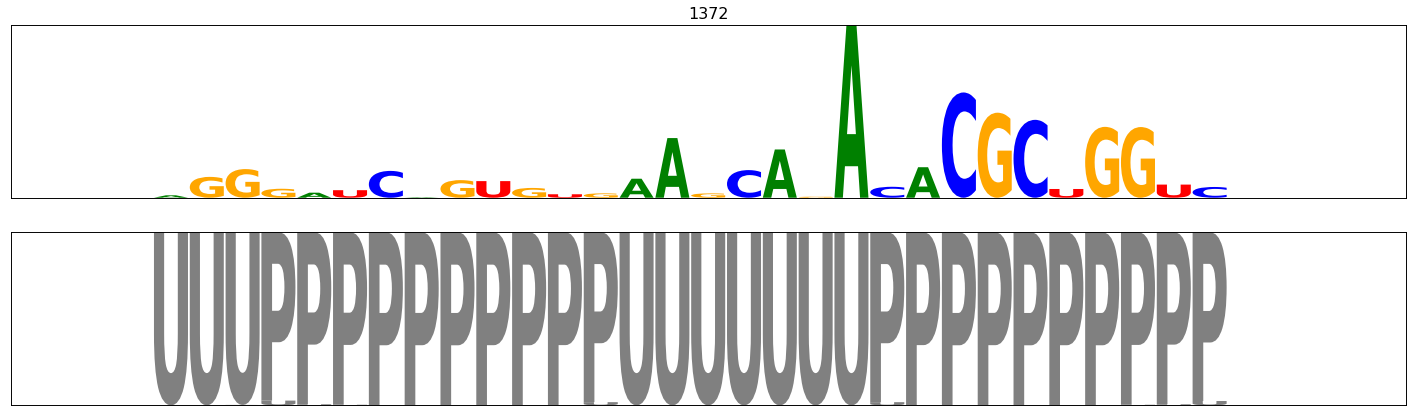

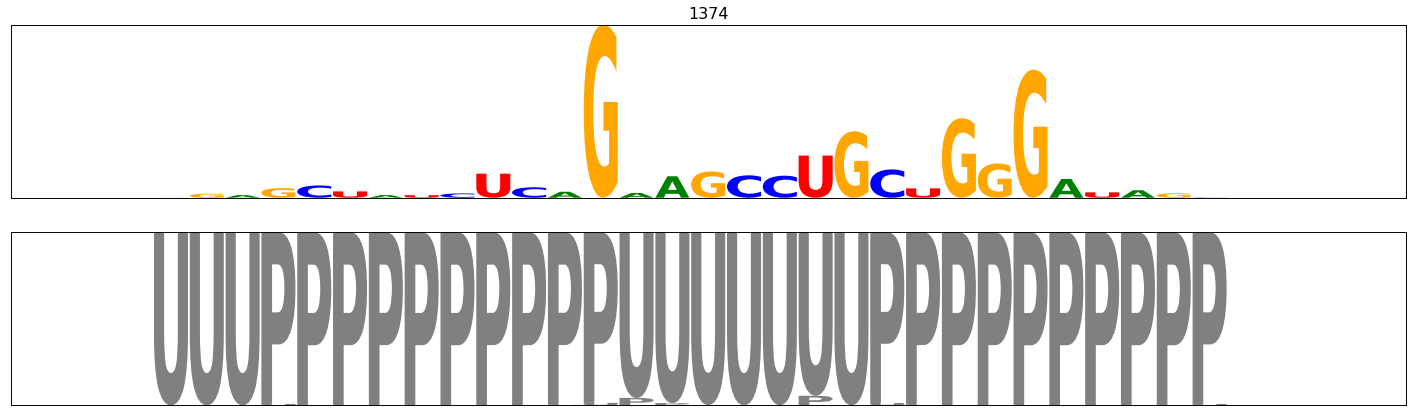

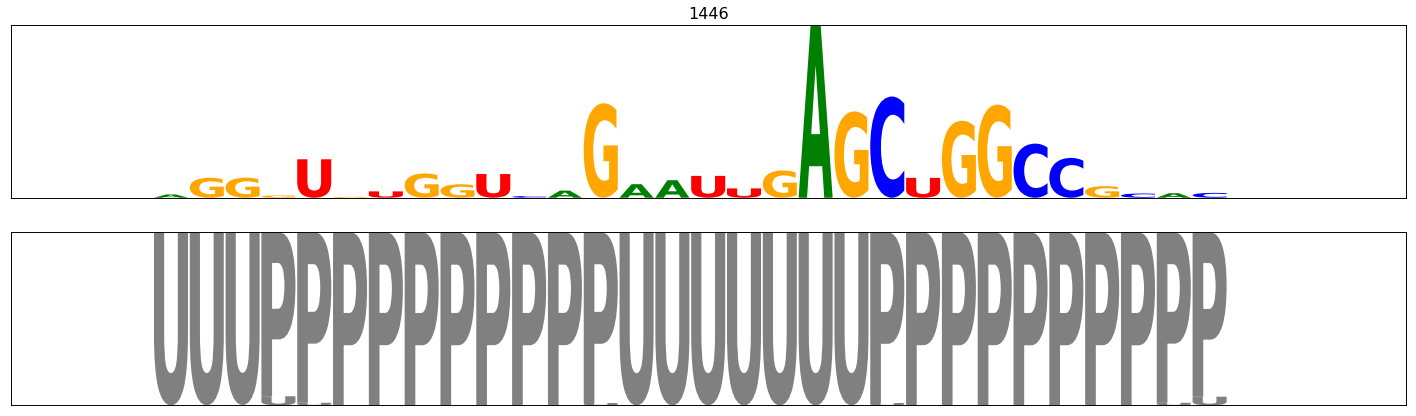

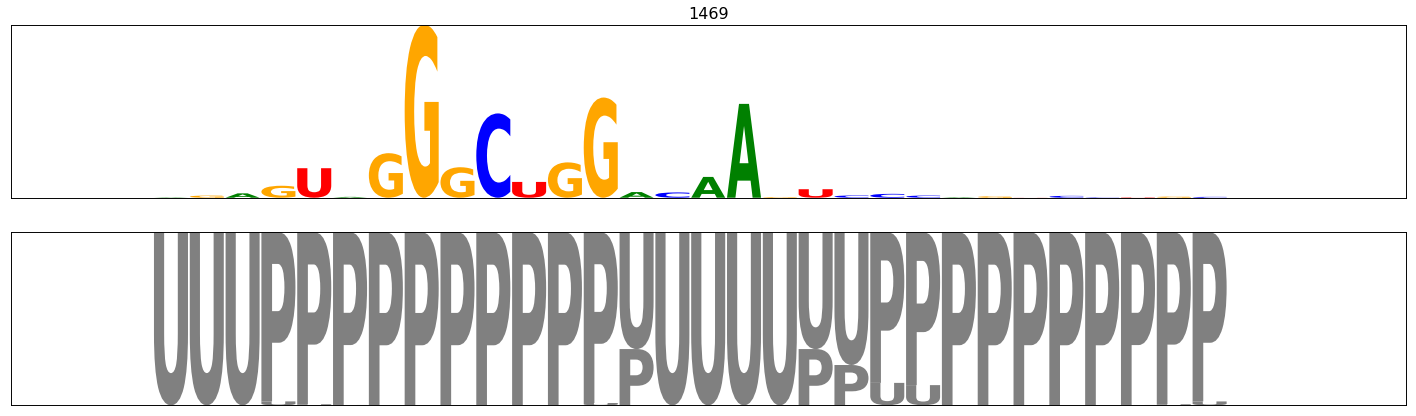

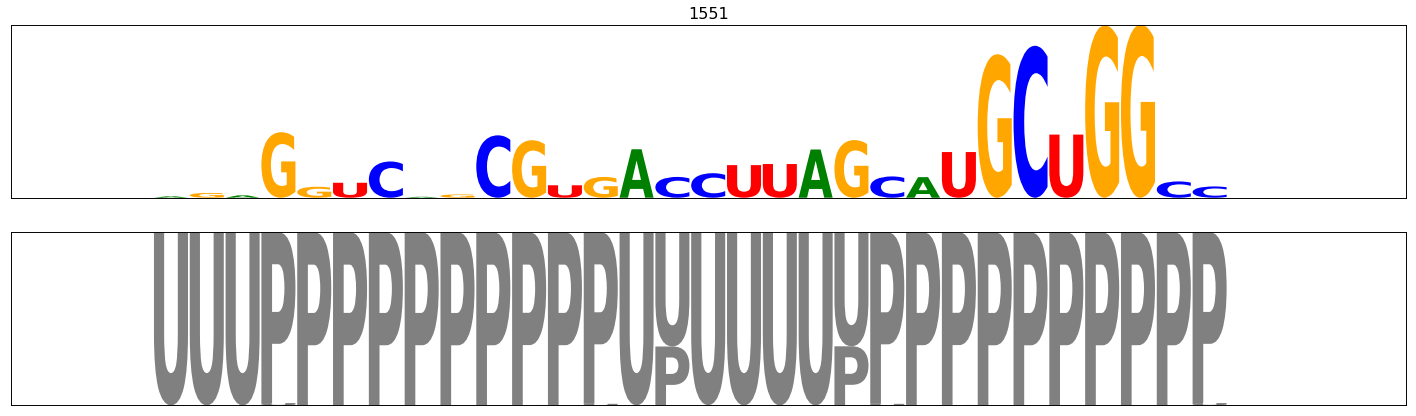

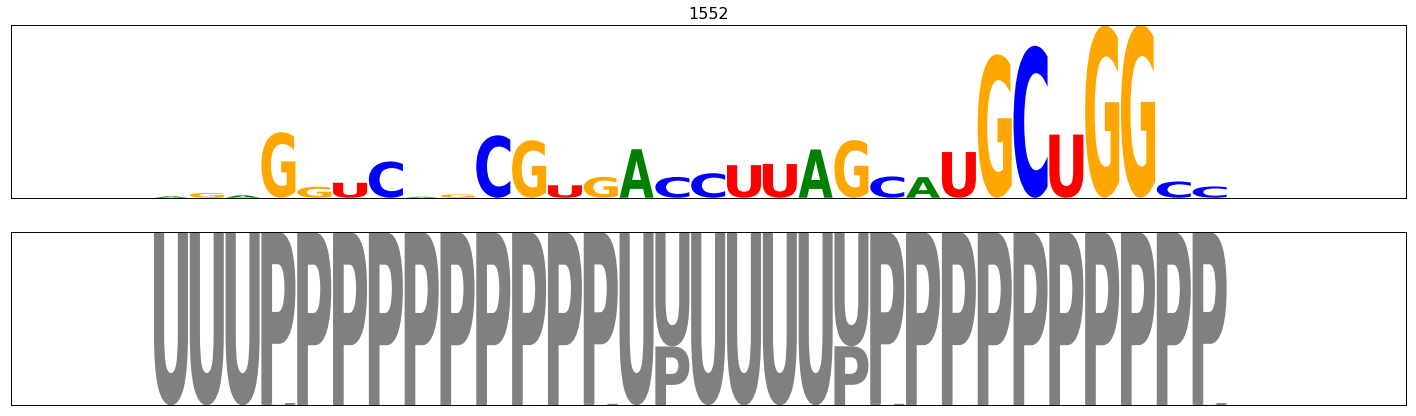

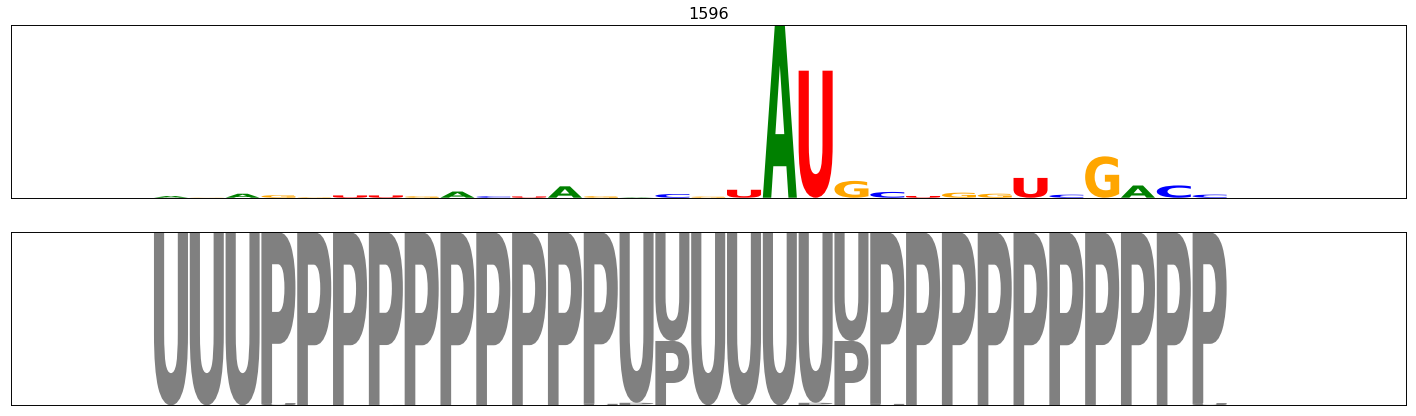

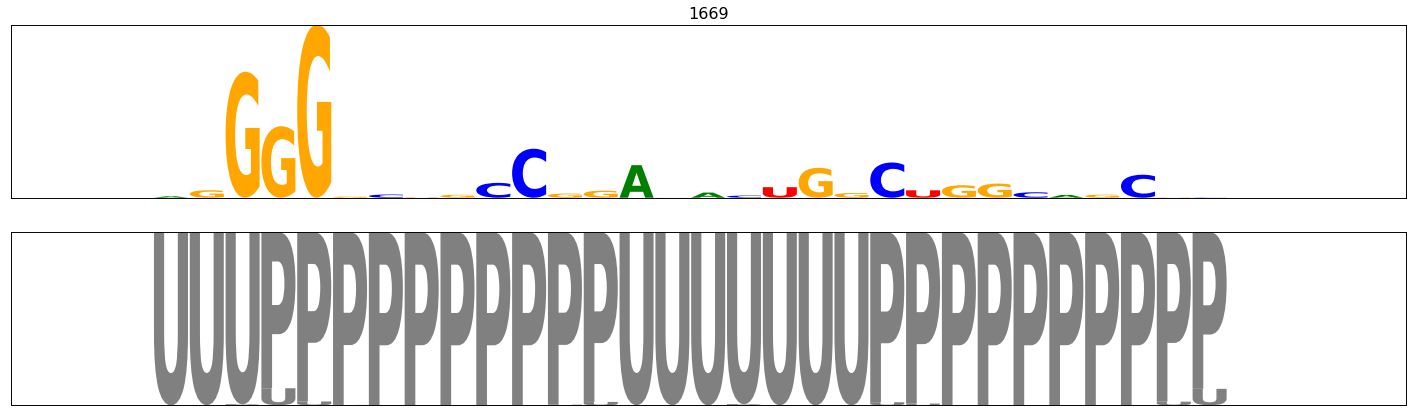

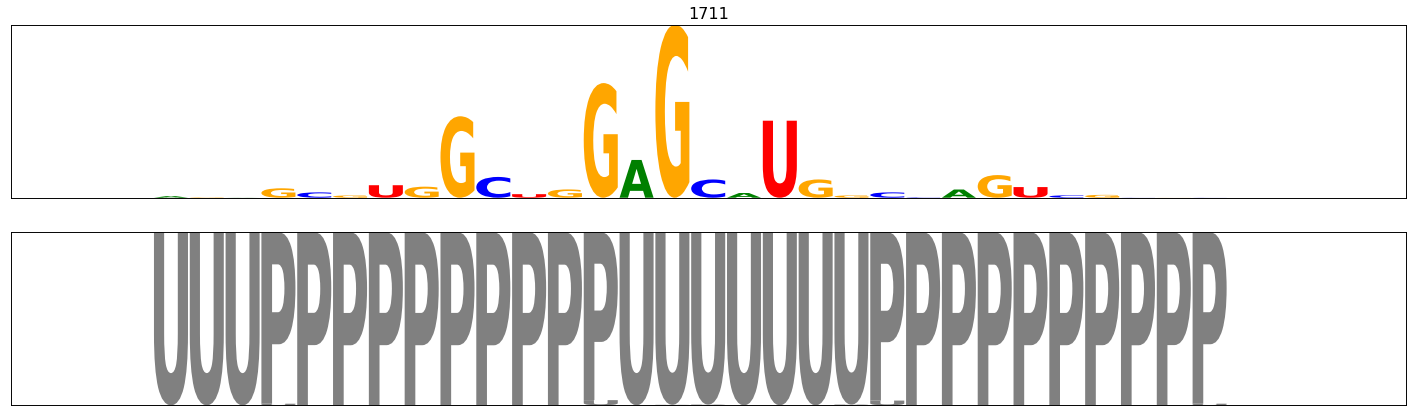

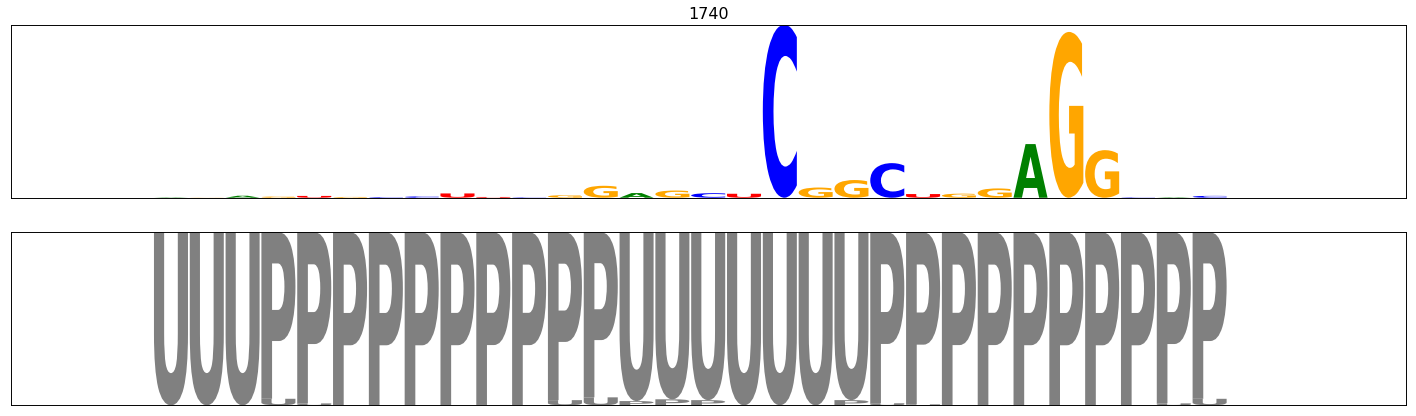

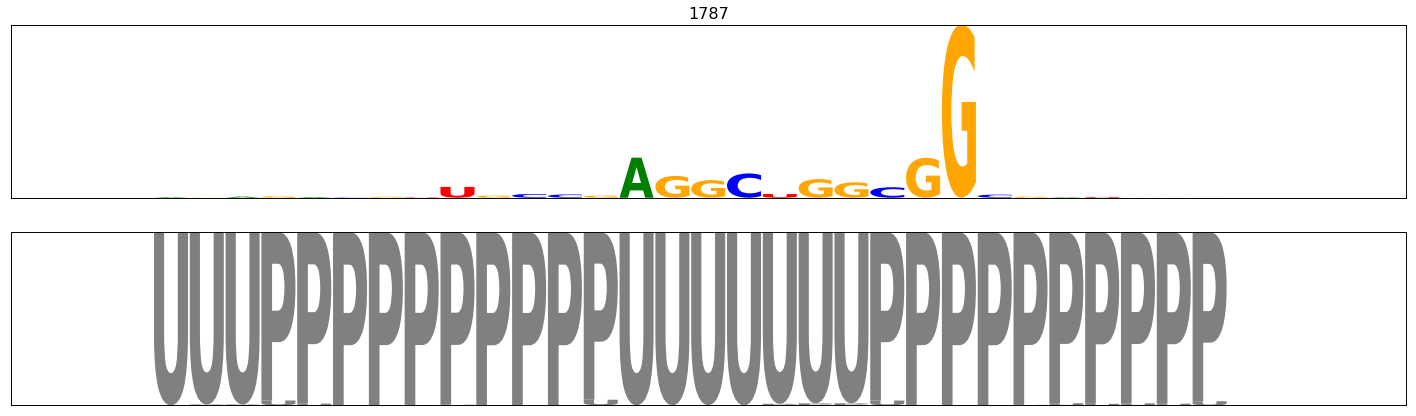

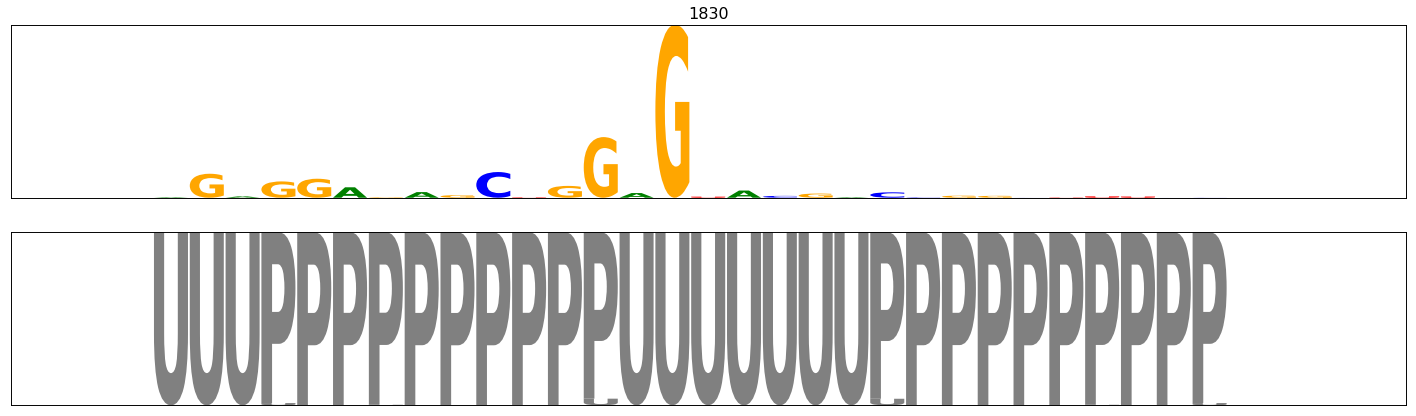

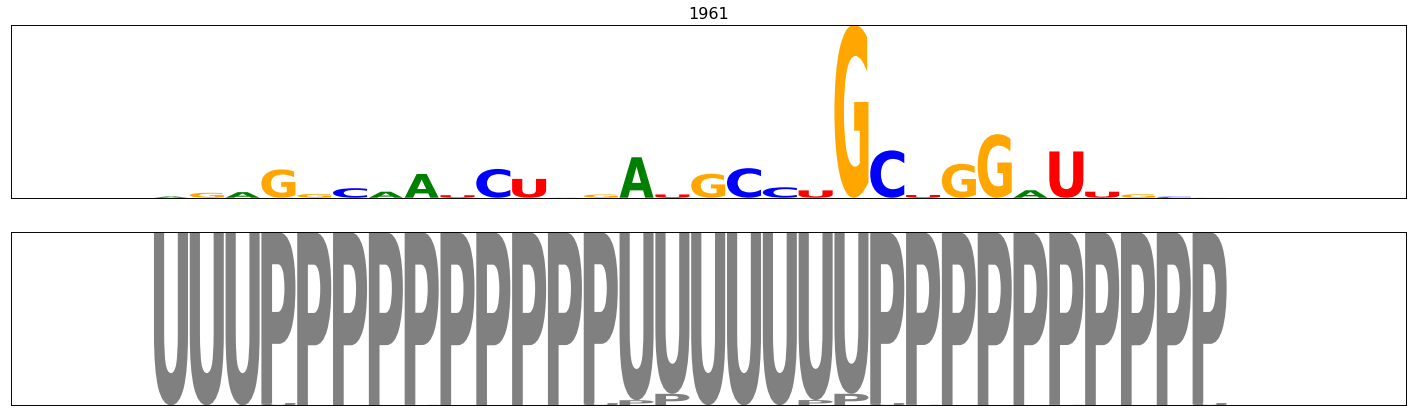

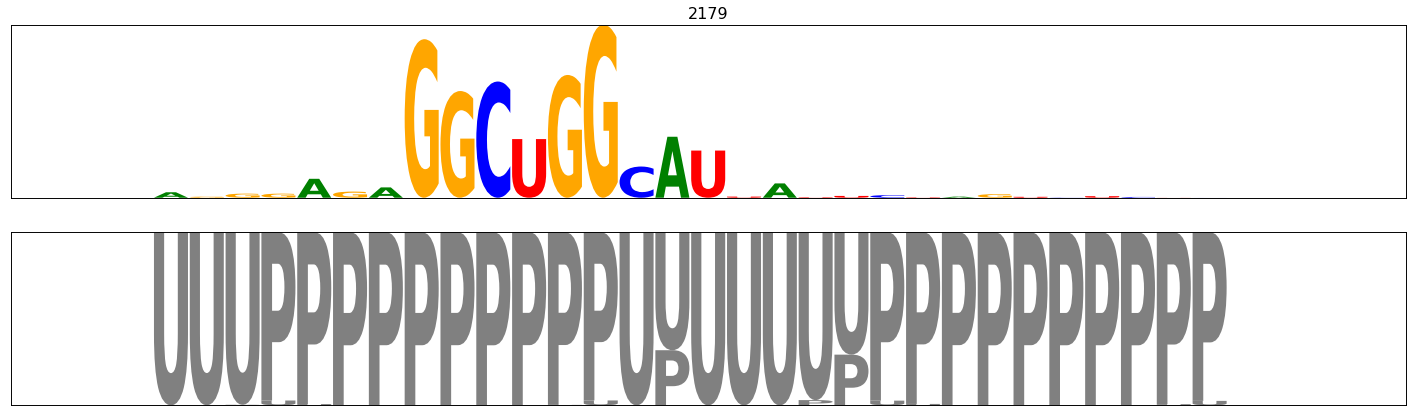

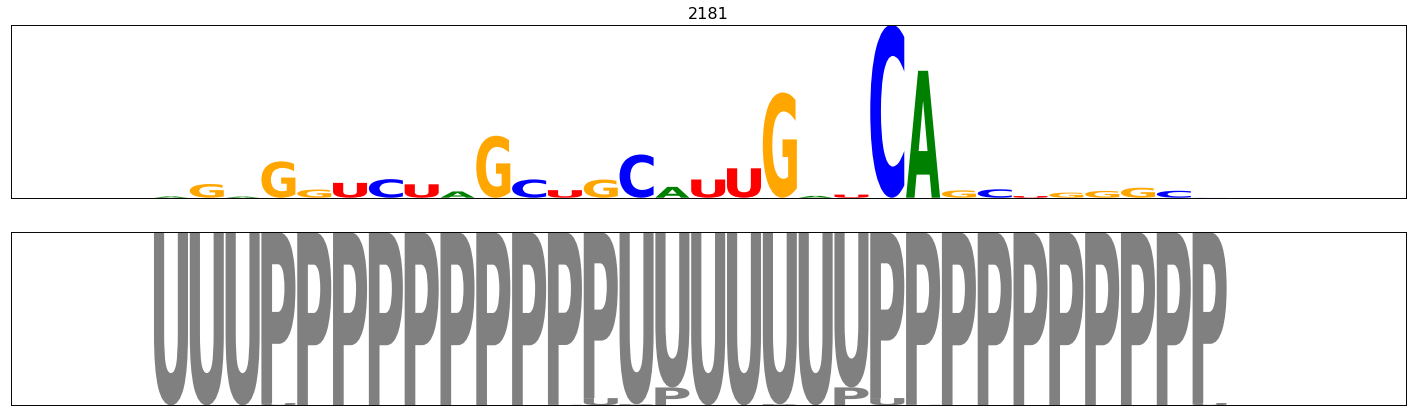

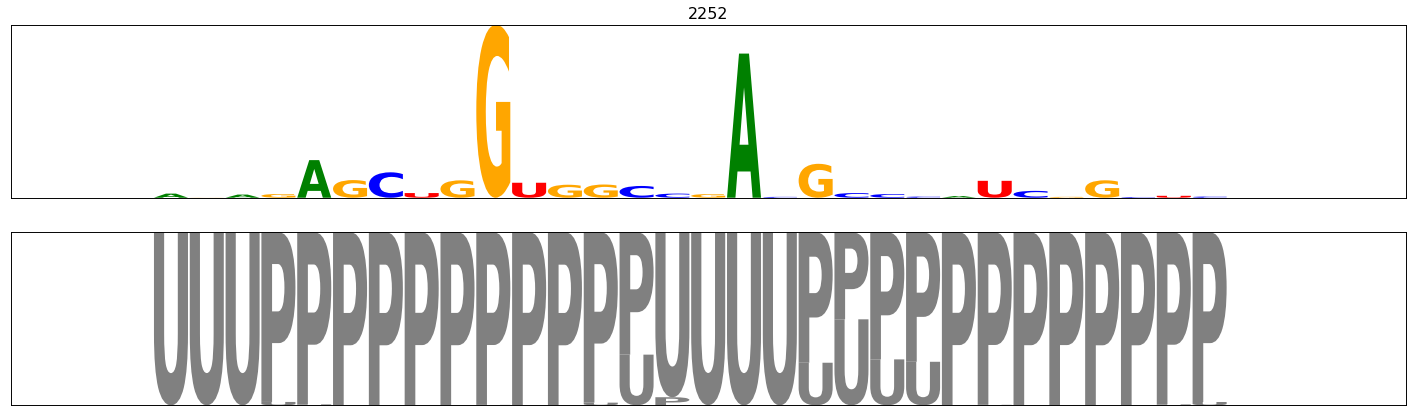

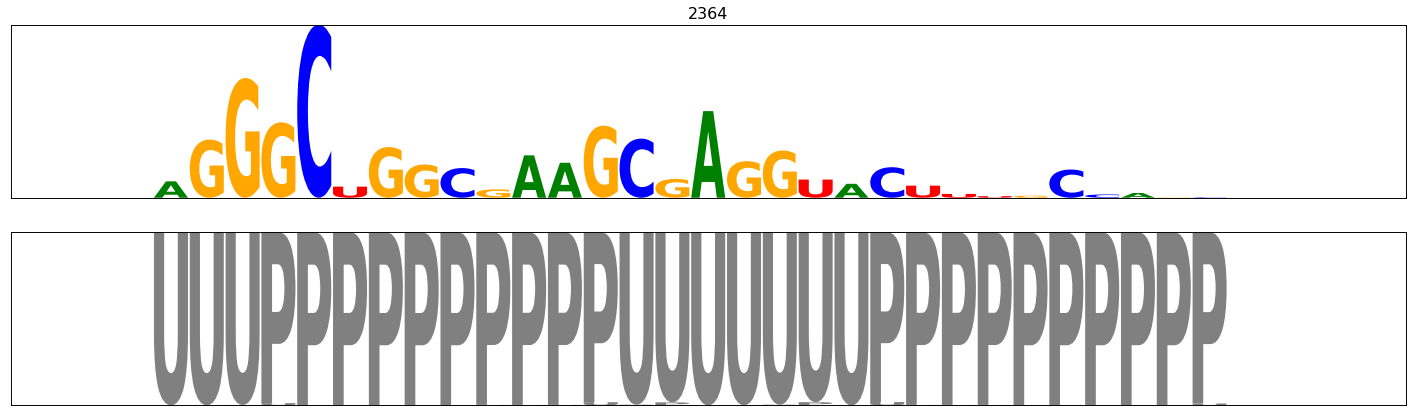

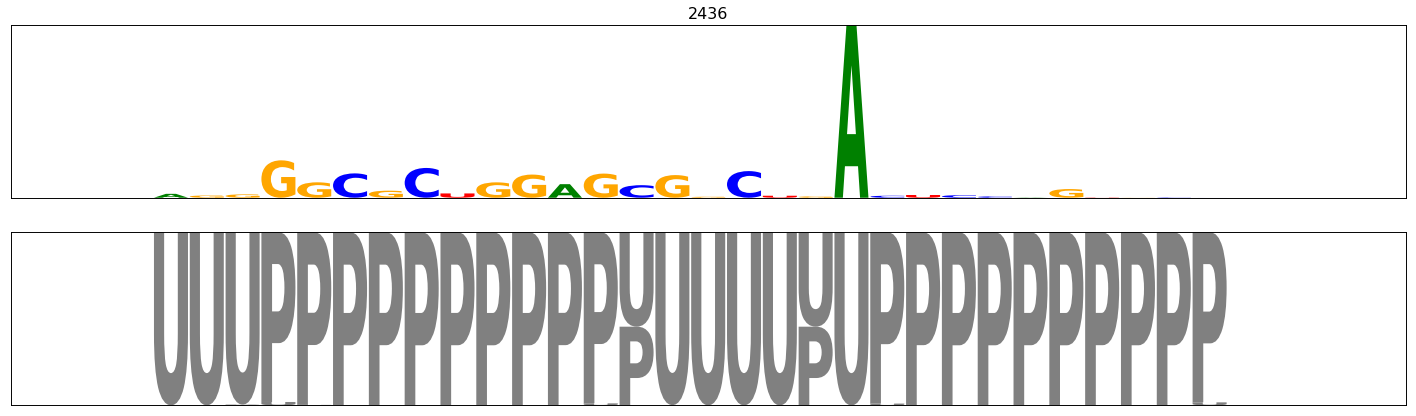

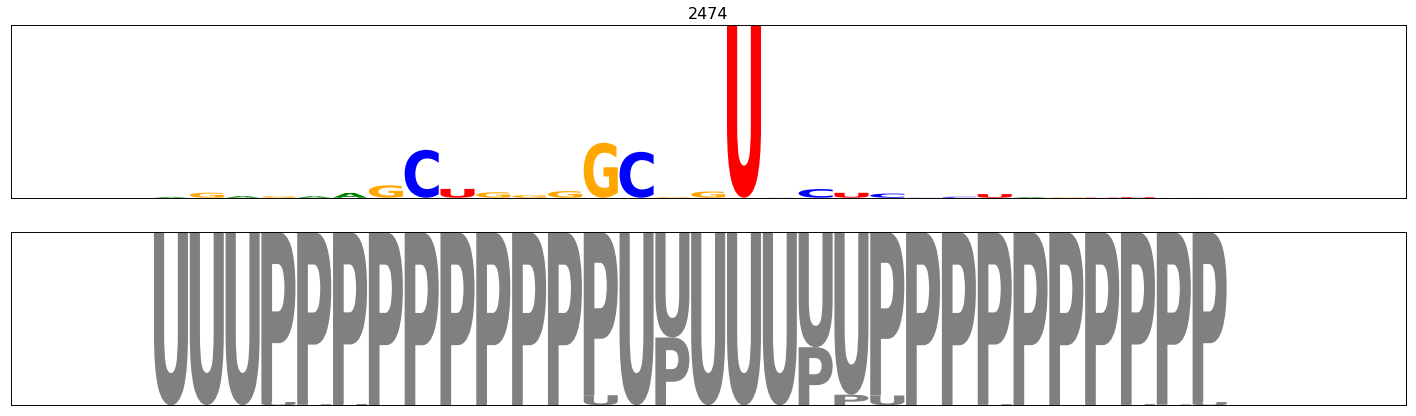

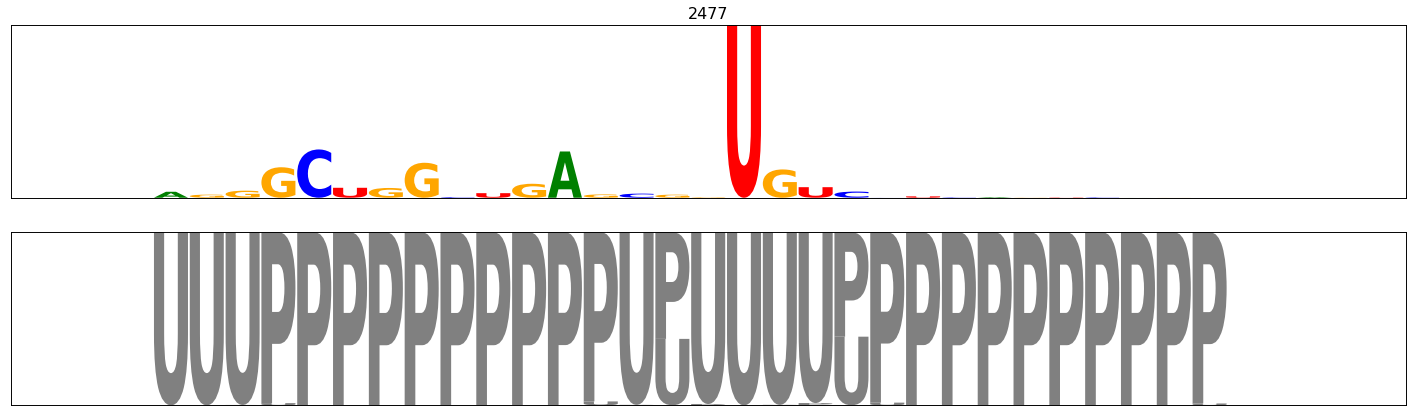

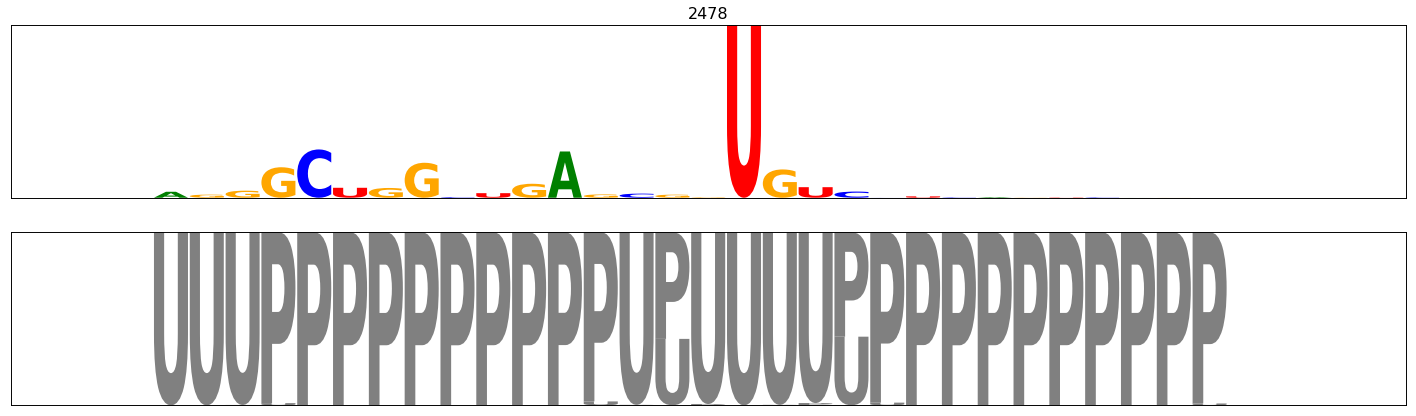

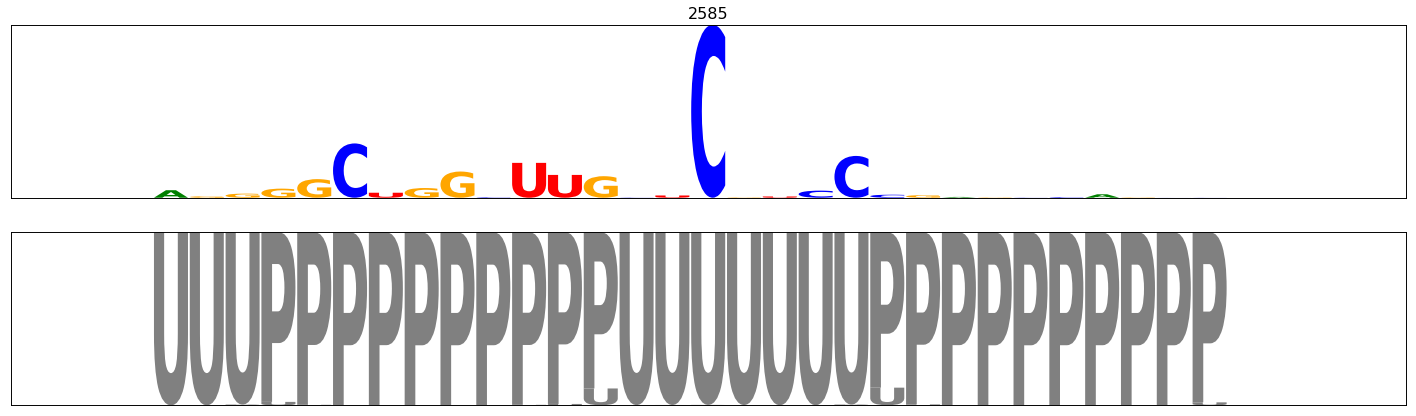

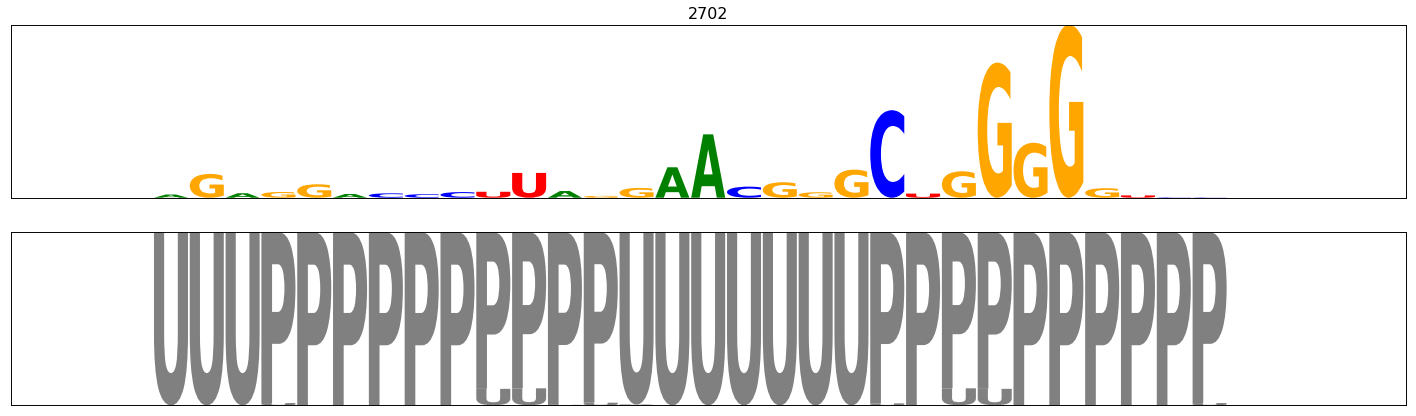

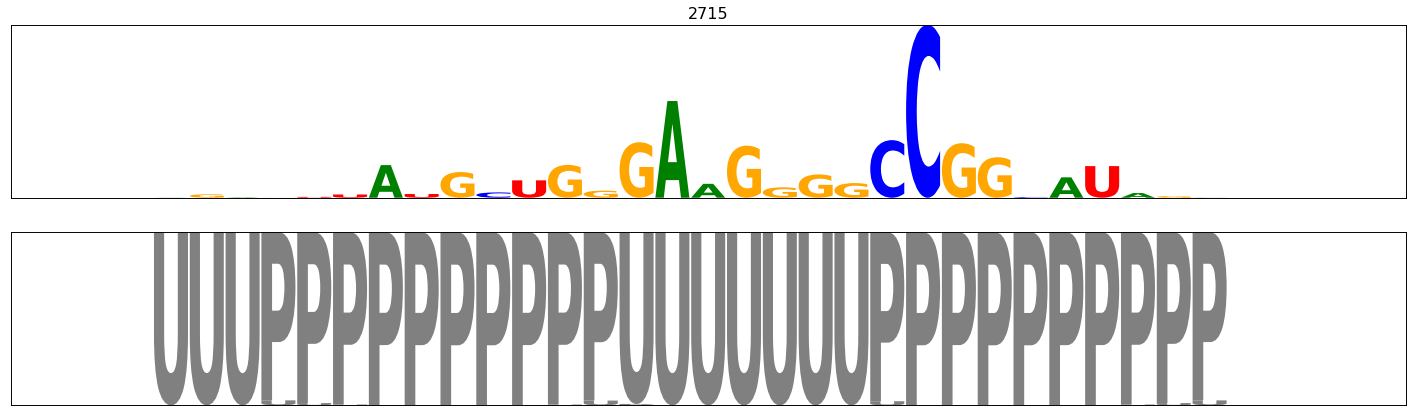

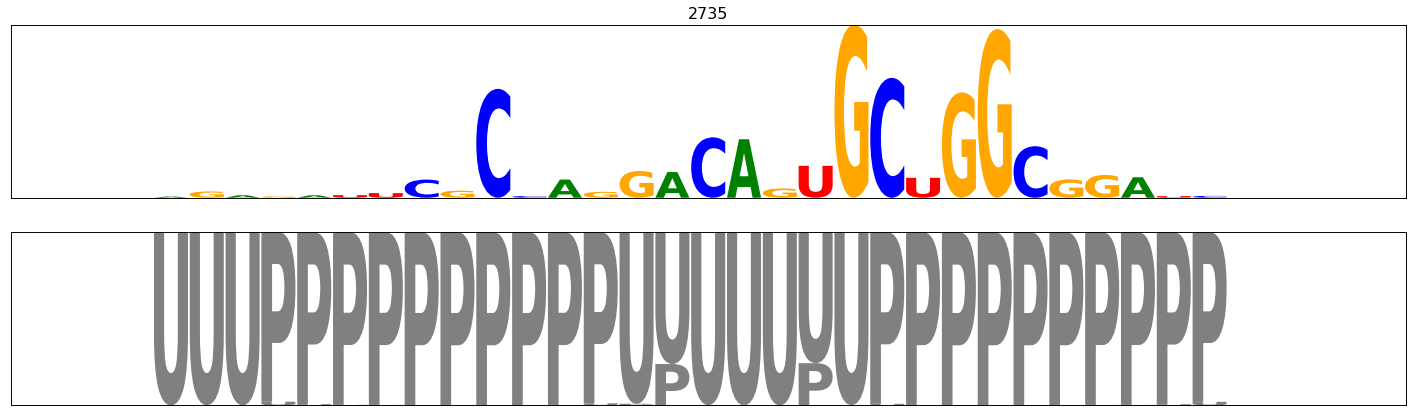

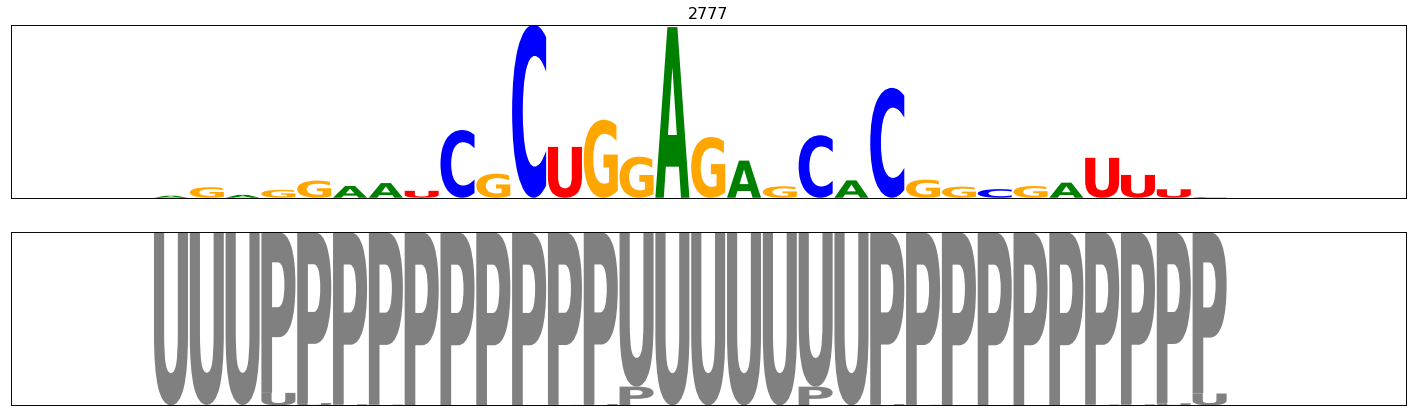

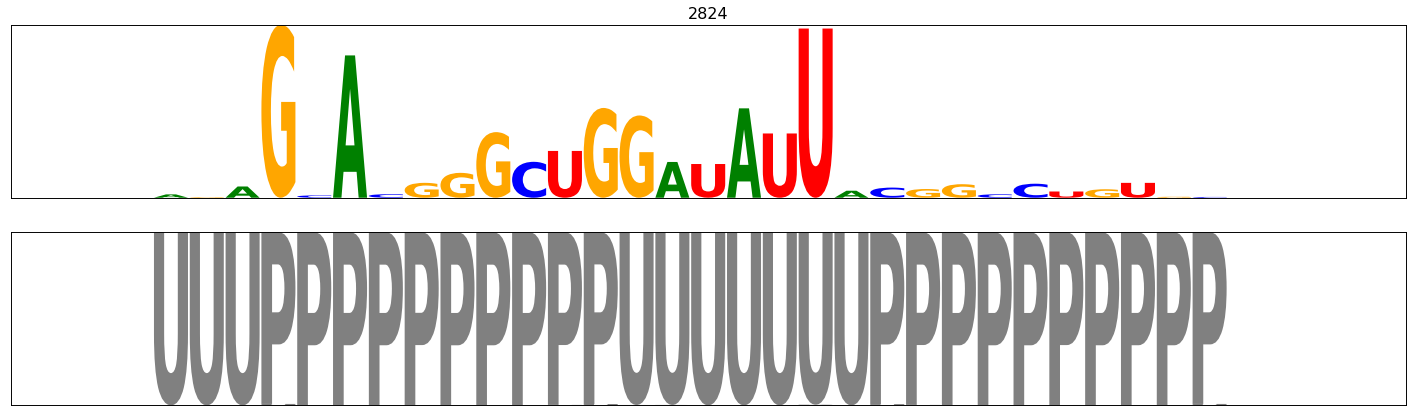

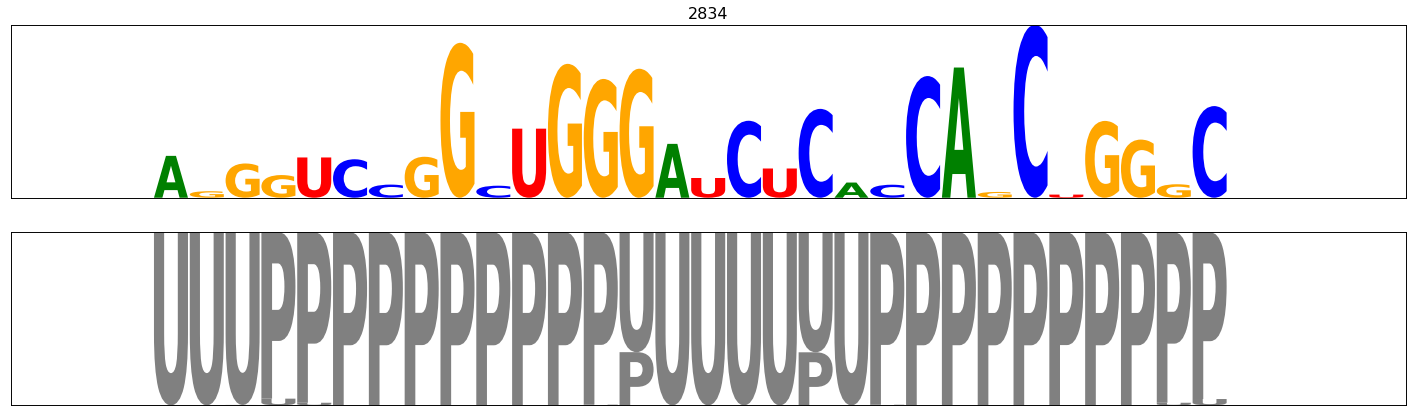

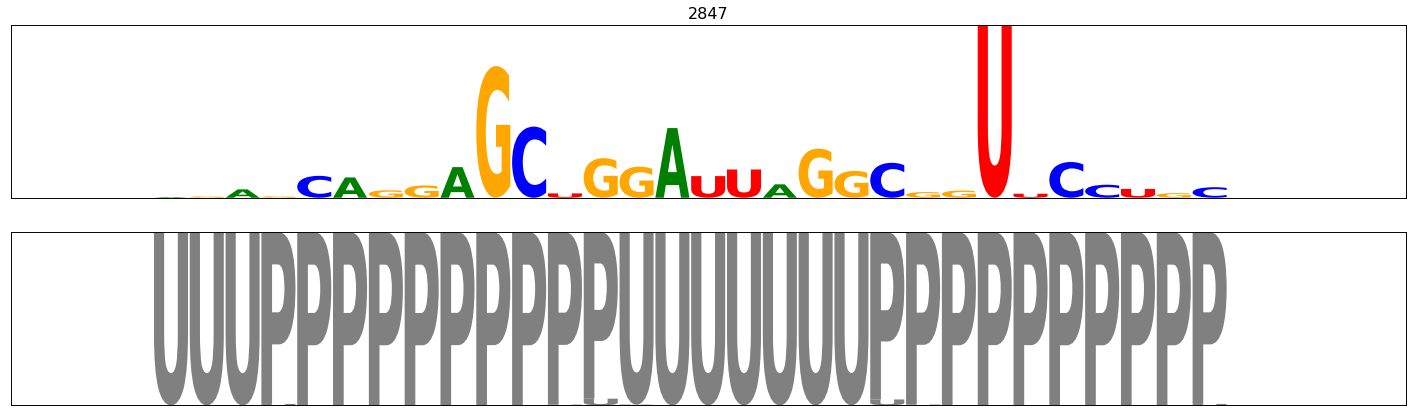

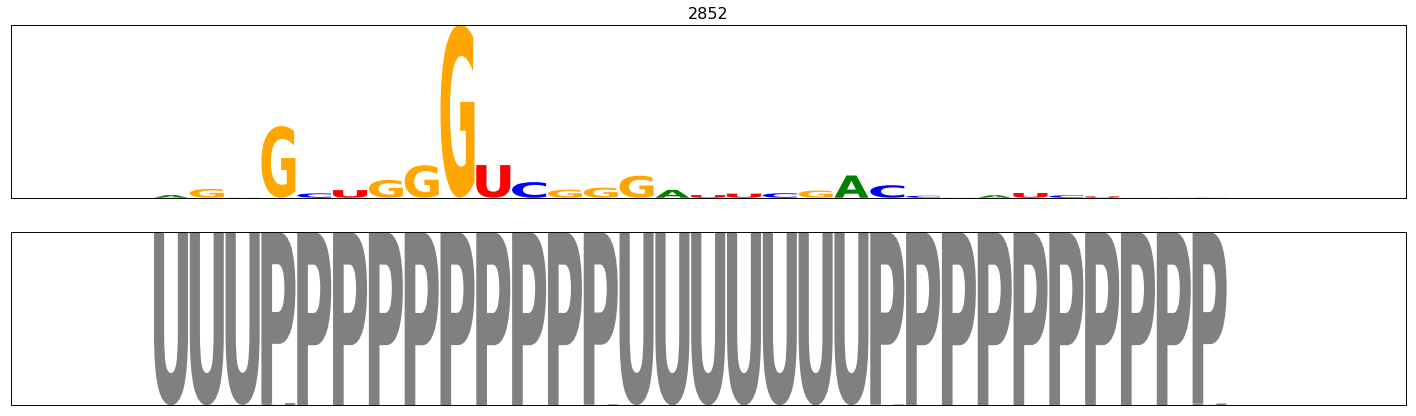

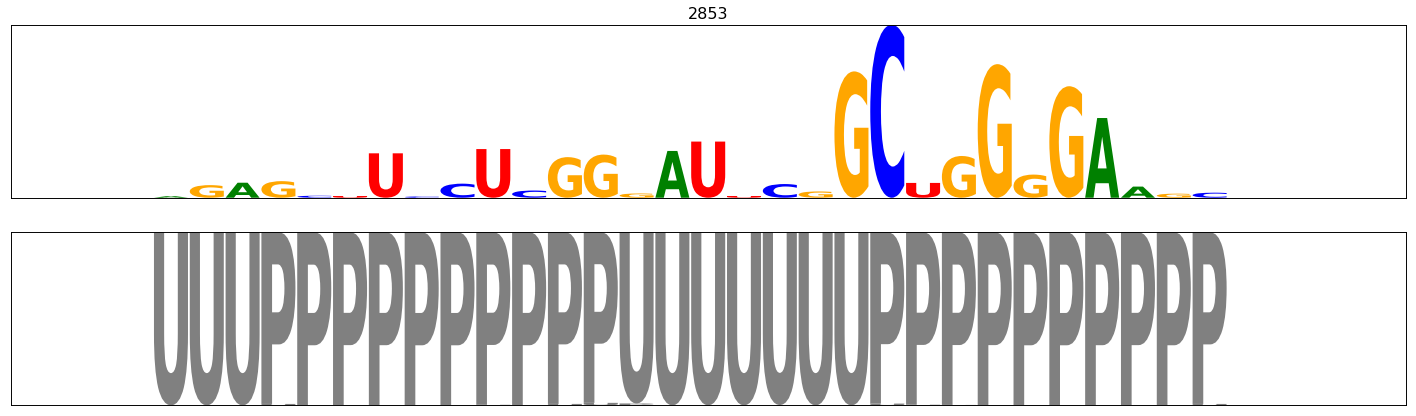

In [15]:
N, L, A = X_low.shape
for k in range(len(X_low)):

    fig = plt.figure(figsize=(25,7))

    
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(4):
        for l in range(L):
            counts_df.iloc[l,a] = attr_map_low[k,l,a]#*X_low[k,l,a]

    ax = plt.subplot(2,1,1)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    plt.title(low_index[k], fontsize=16)
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])
    
    counts_df = pd.DataFrame(data=0.0, columns=list('PU'), index=list(range(L)))
    for a in range(2):
        for l in range(L):
            counts_df.iloc[l,a] = X_low[k,l,a+4]

    ax = plt.subplot(2,1,2)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])

# plot mutagenesis maps for high binding scores

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


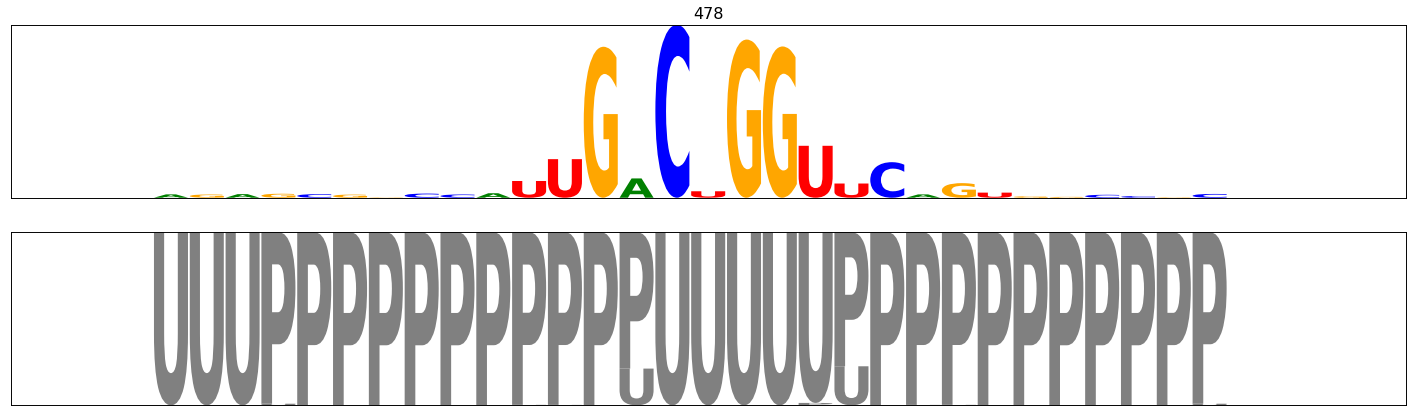

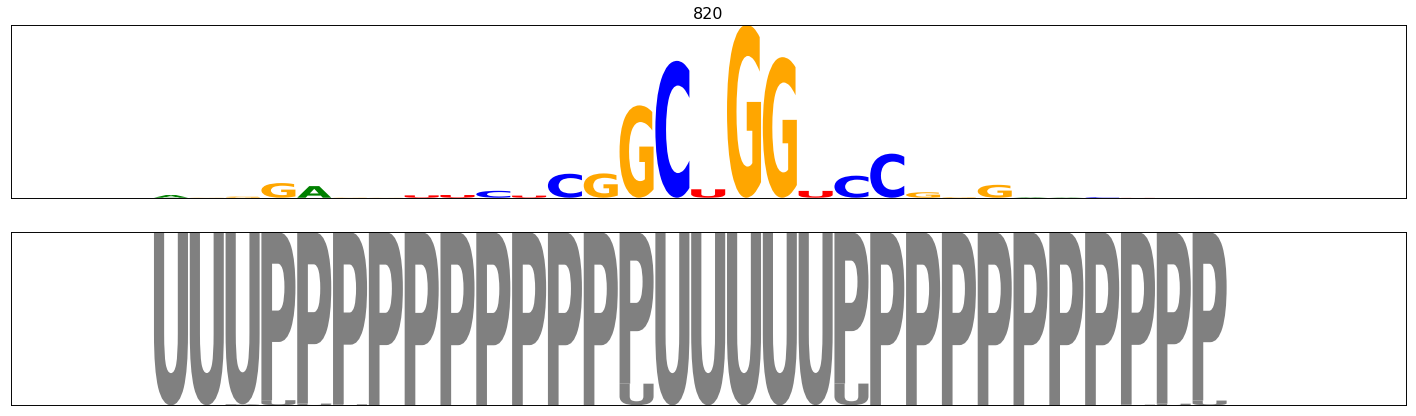

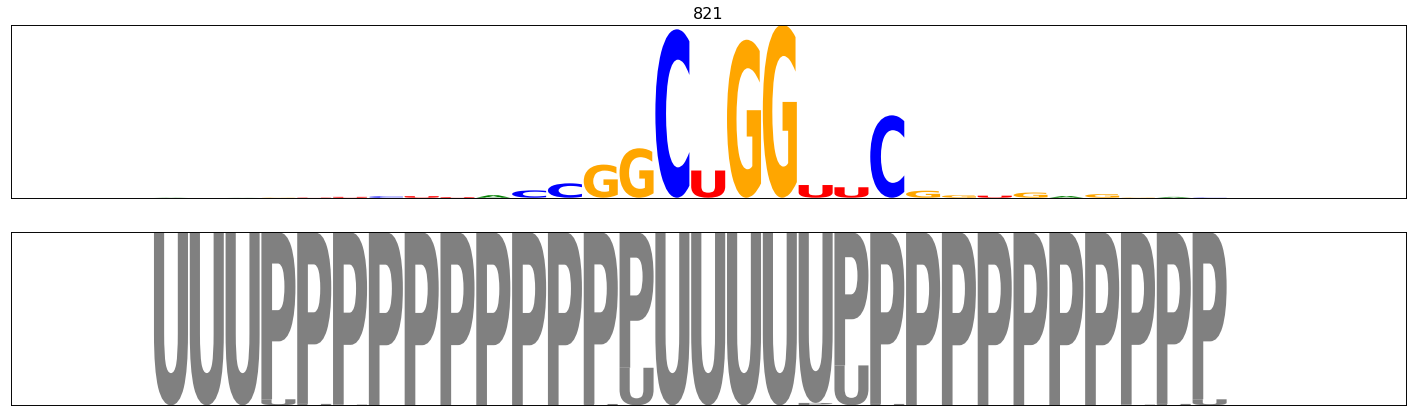

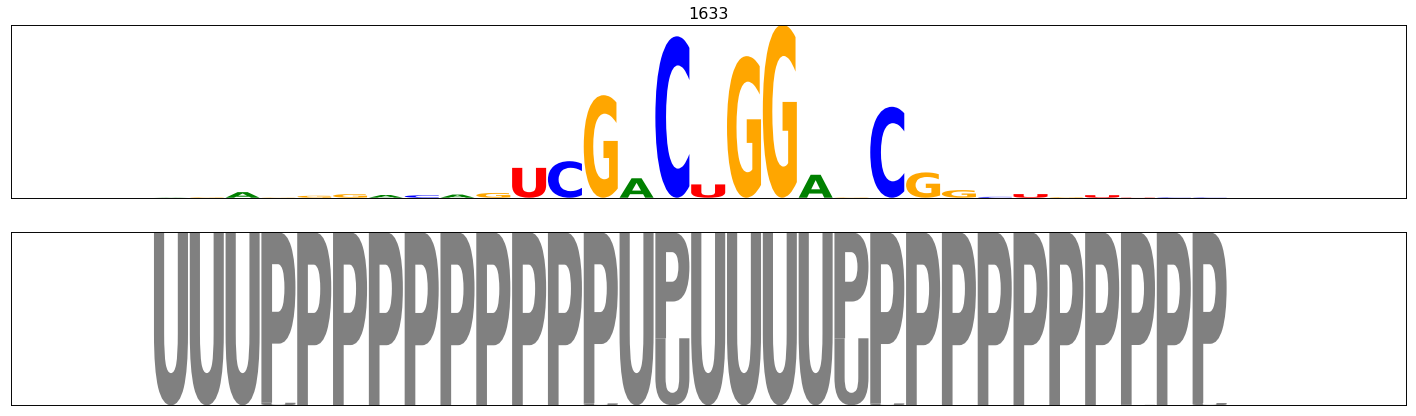

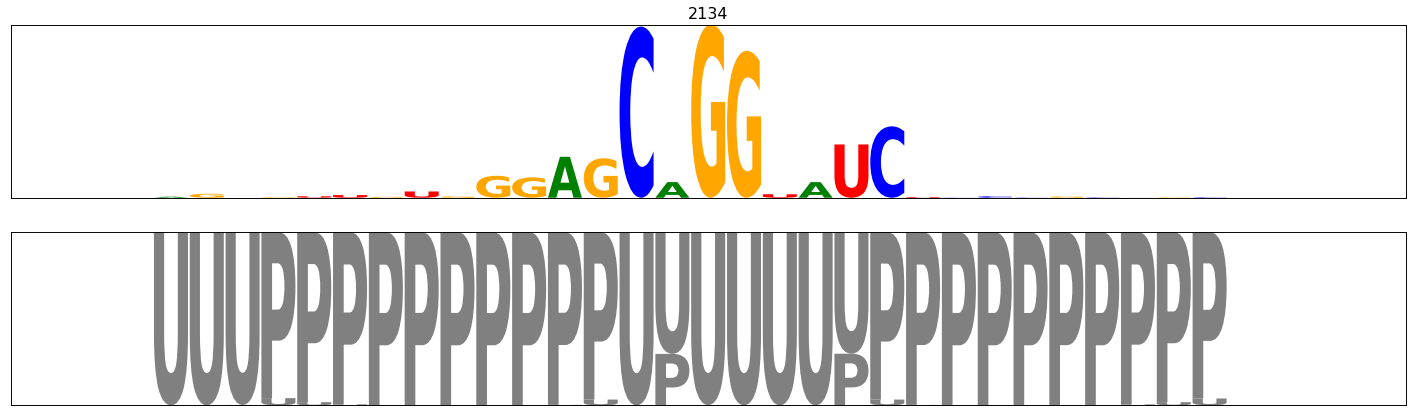

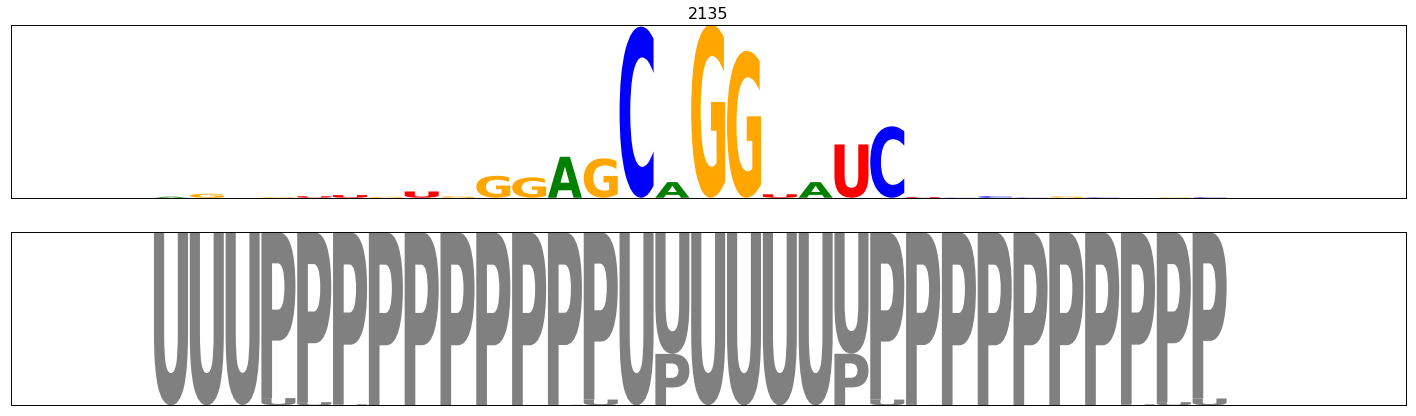

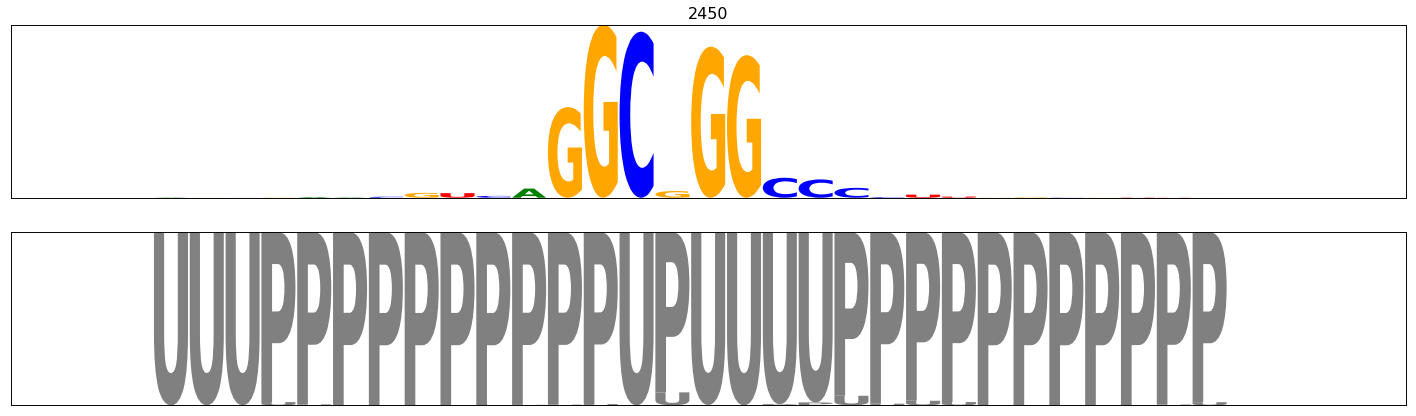

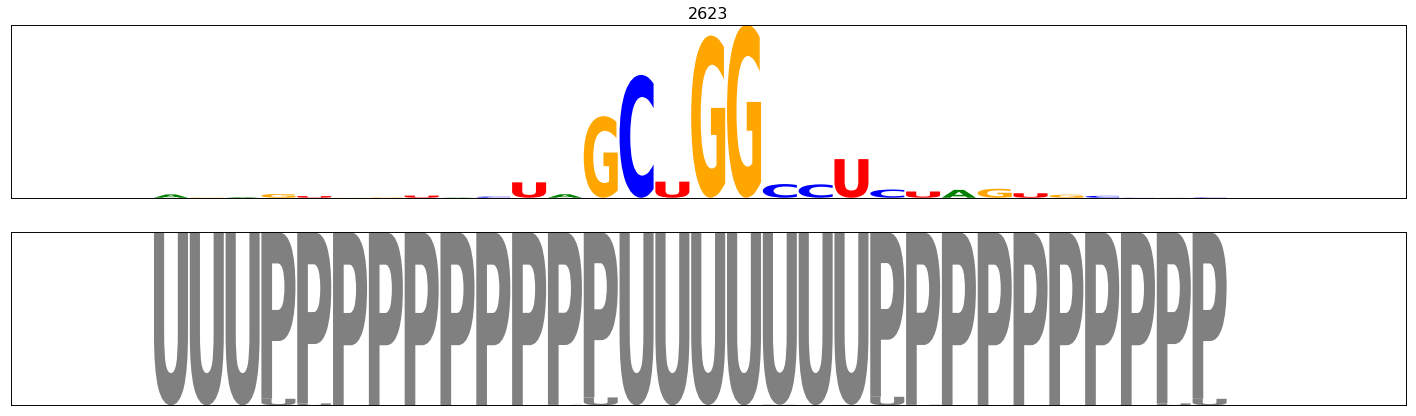

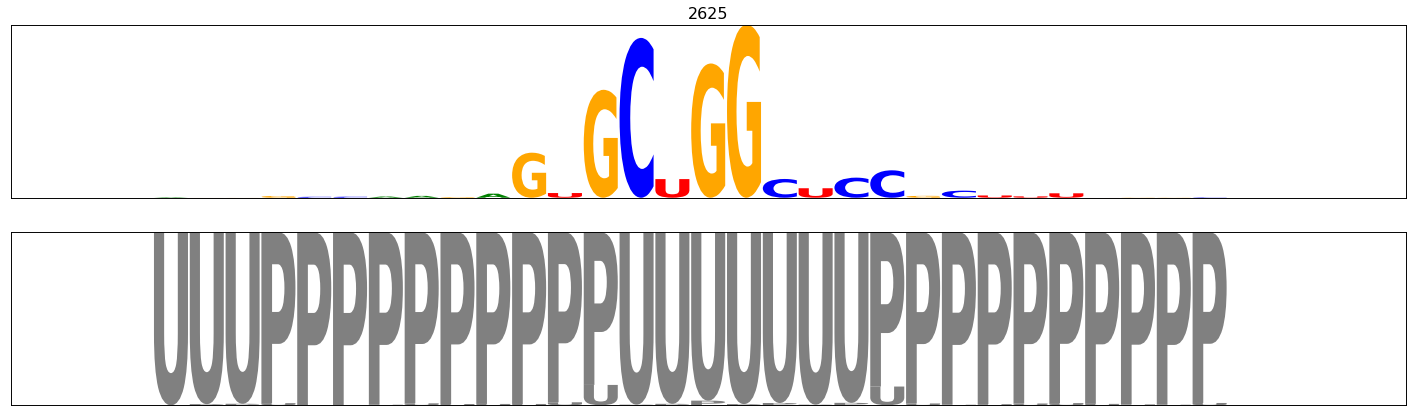

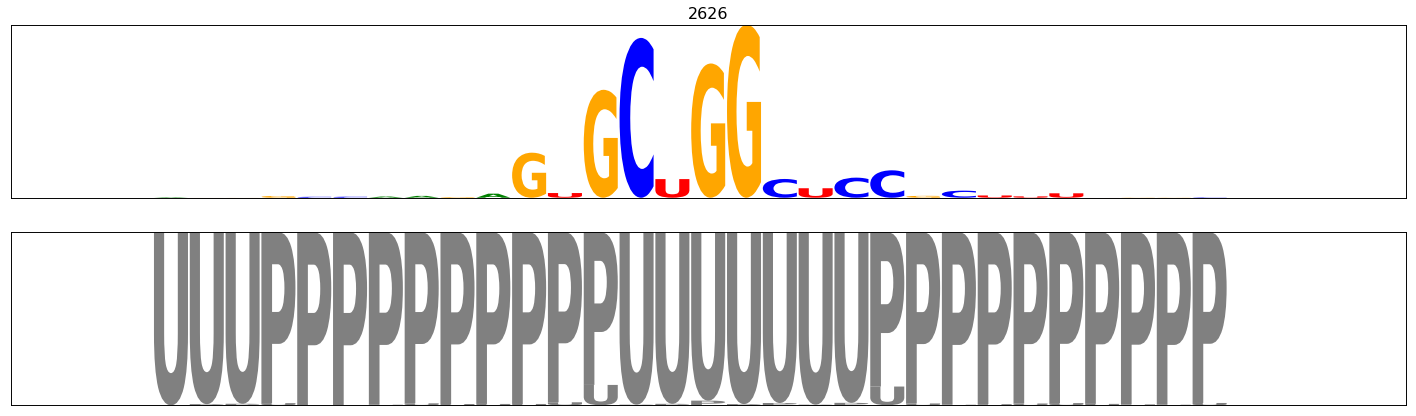

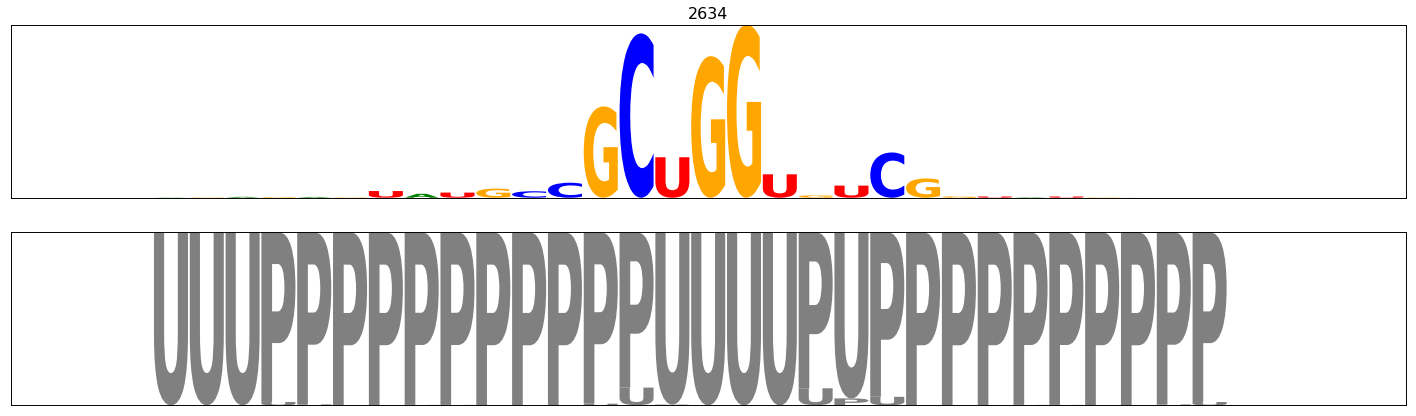

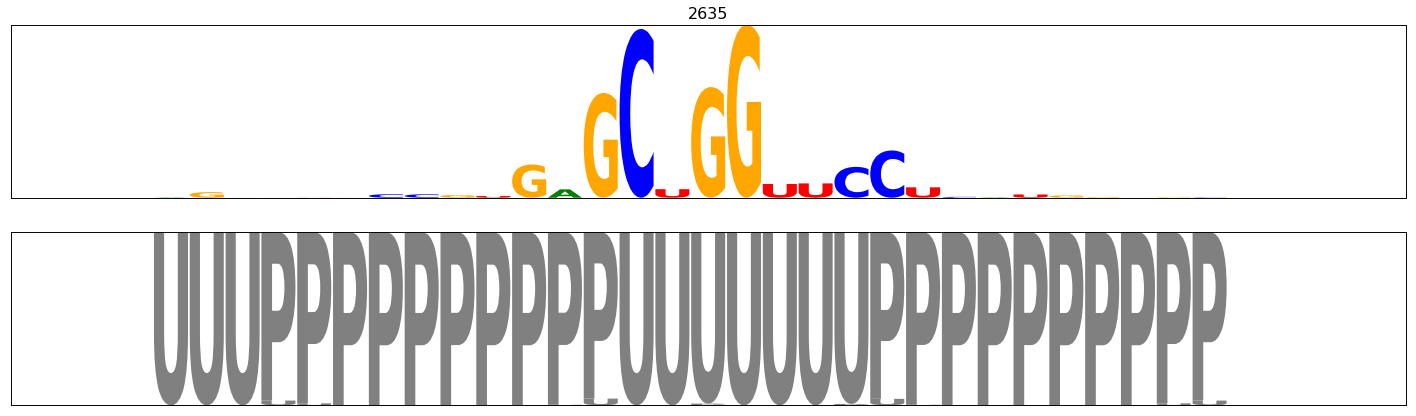

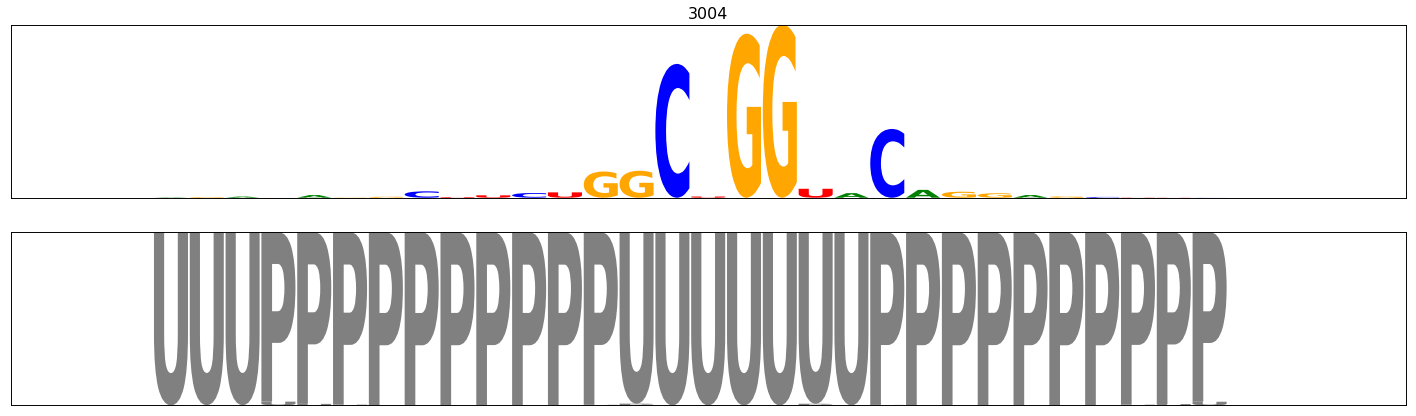

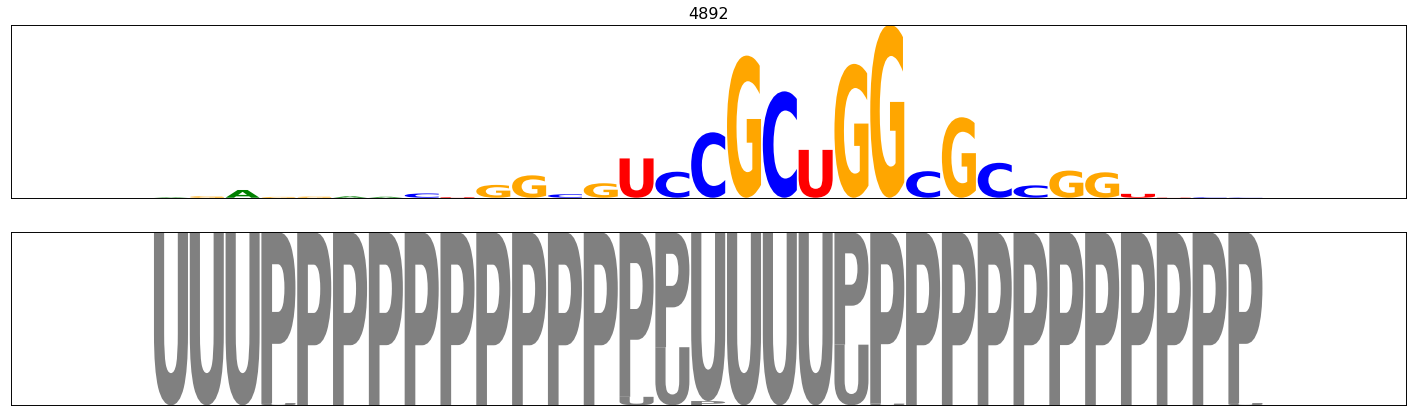

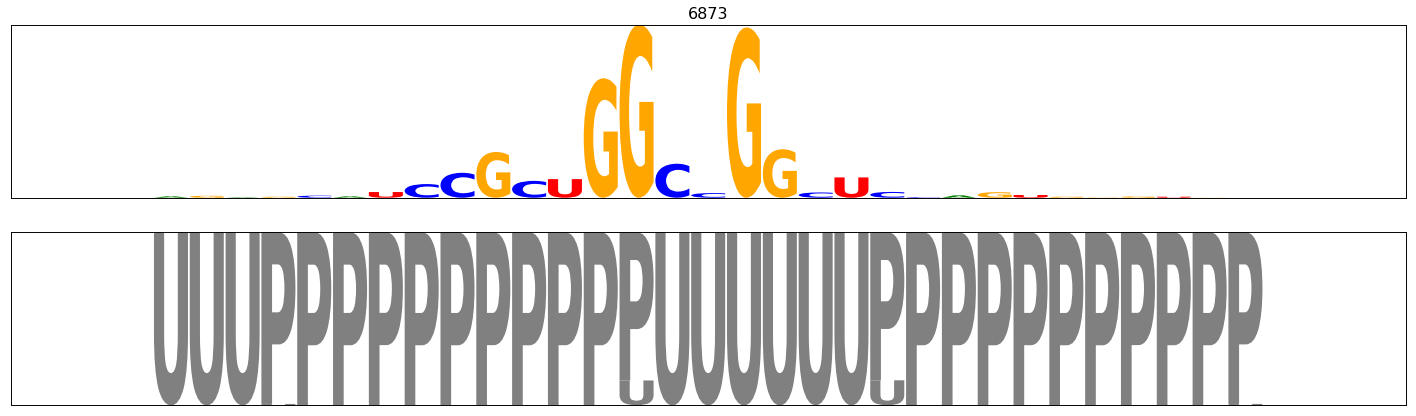

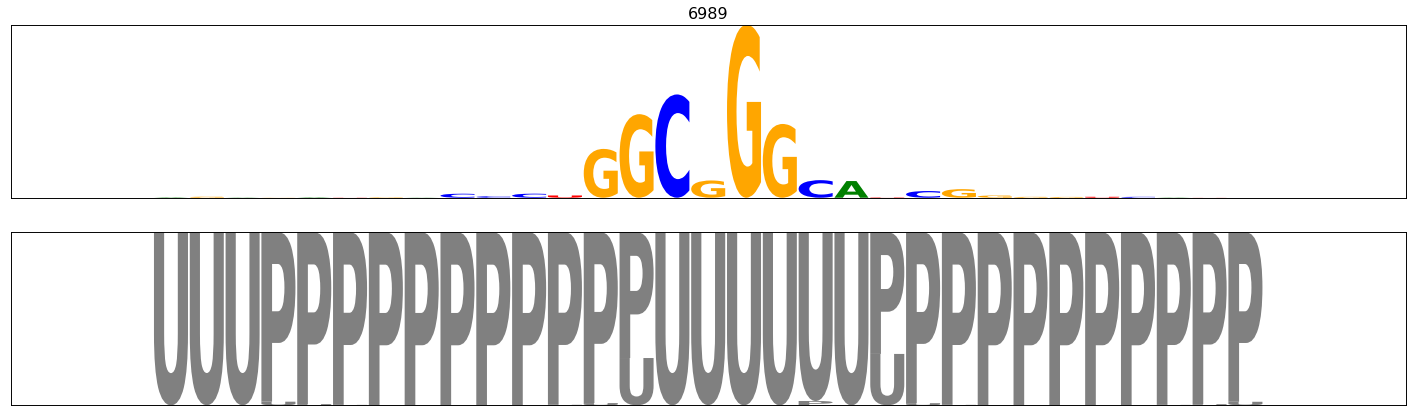

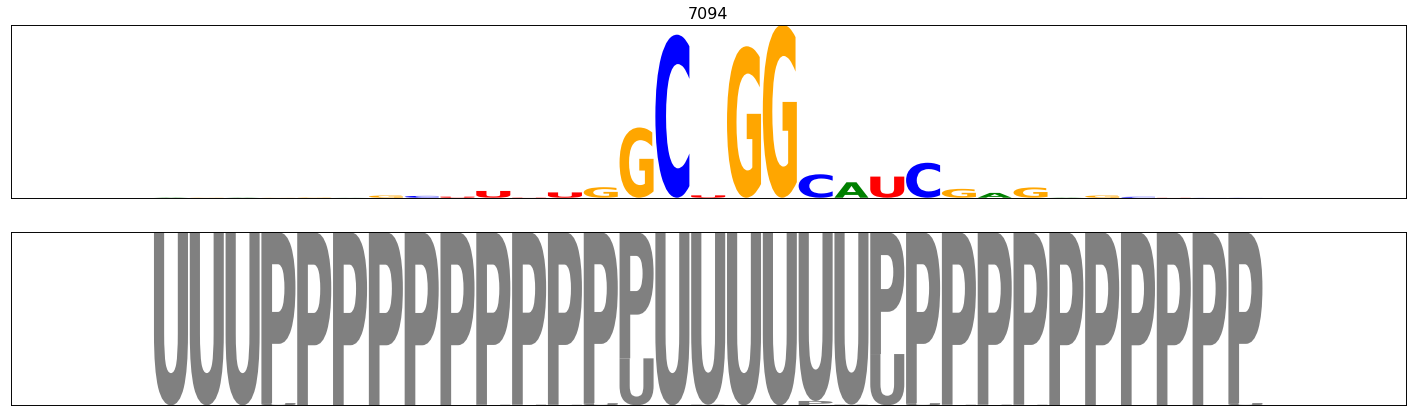

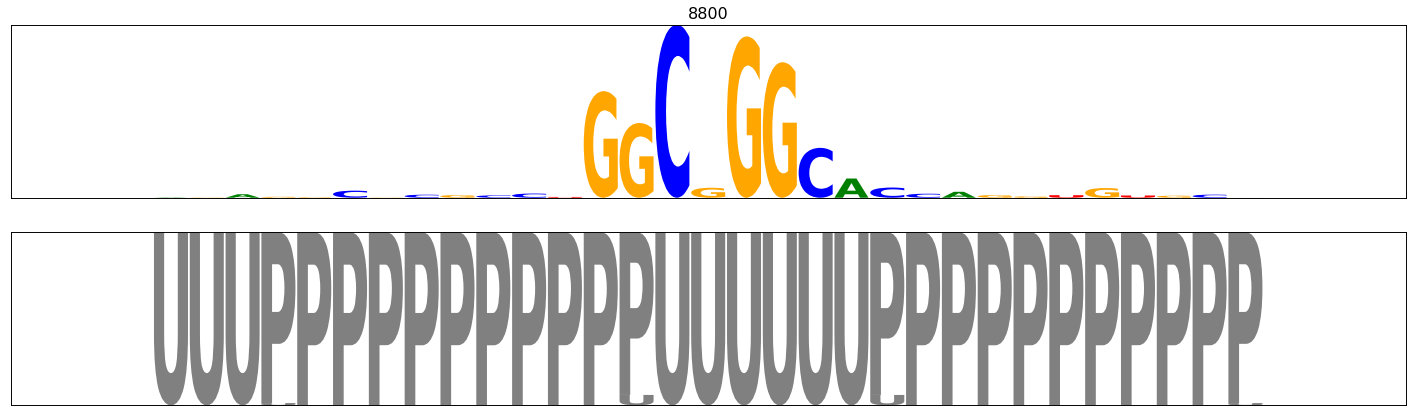

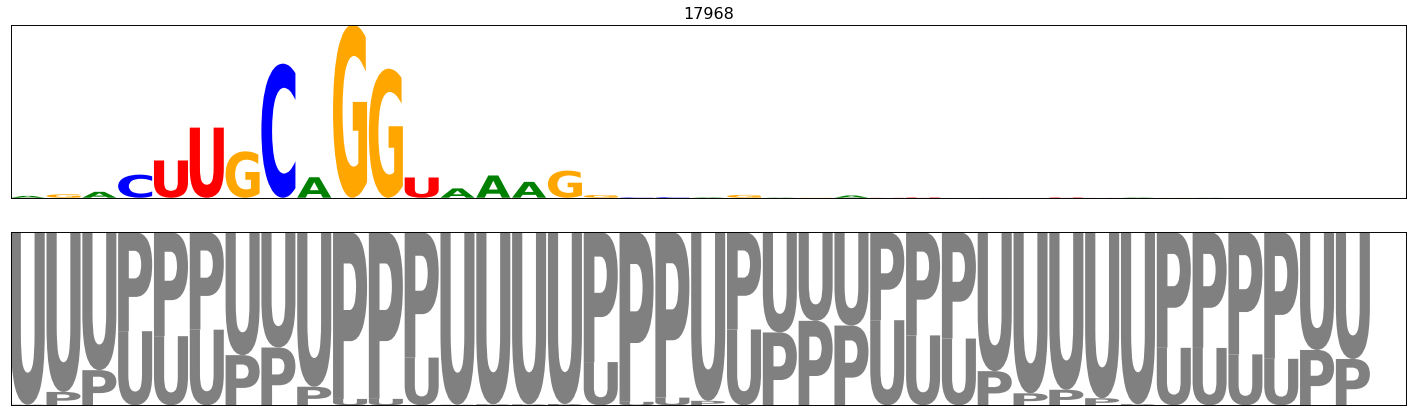

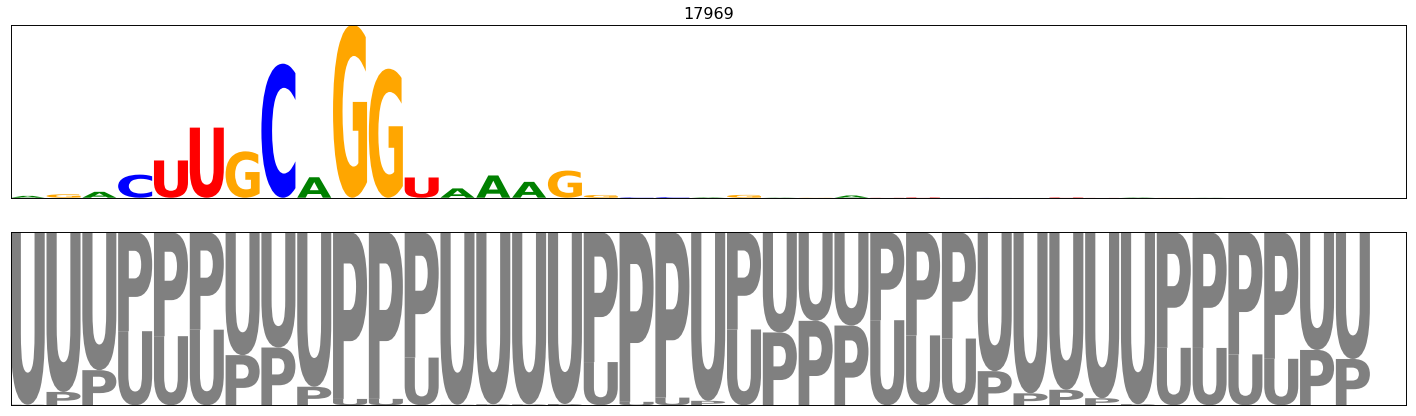

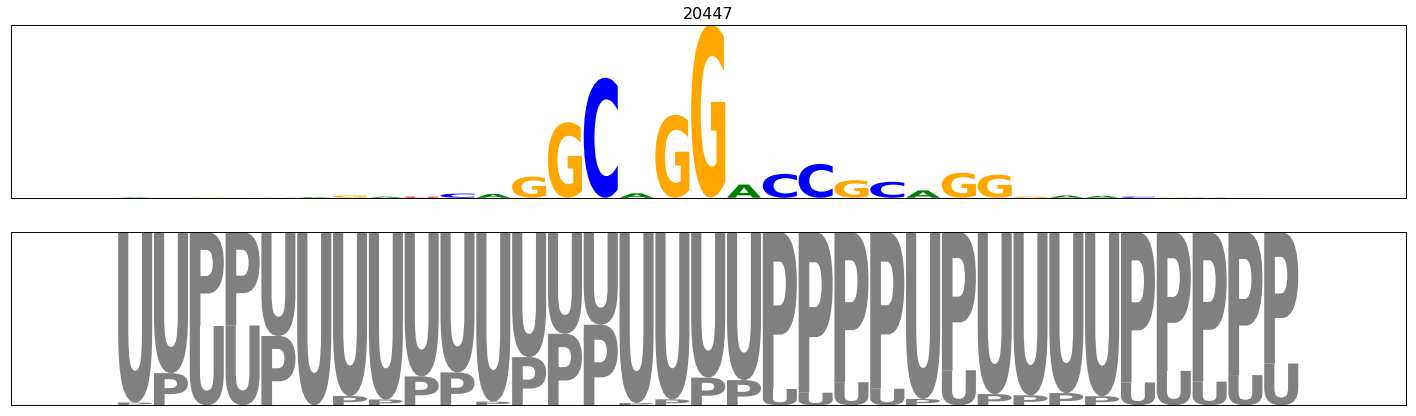

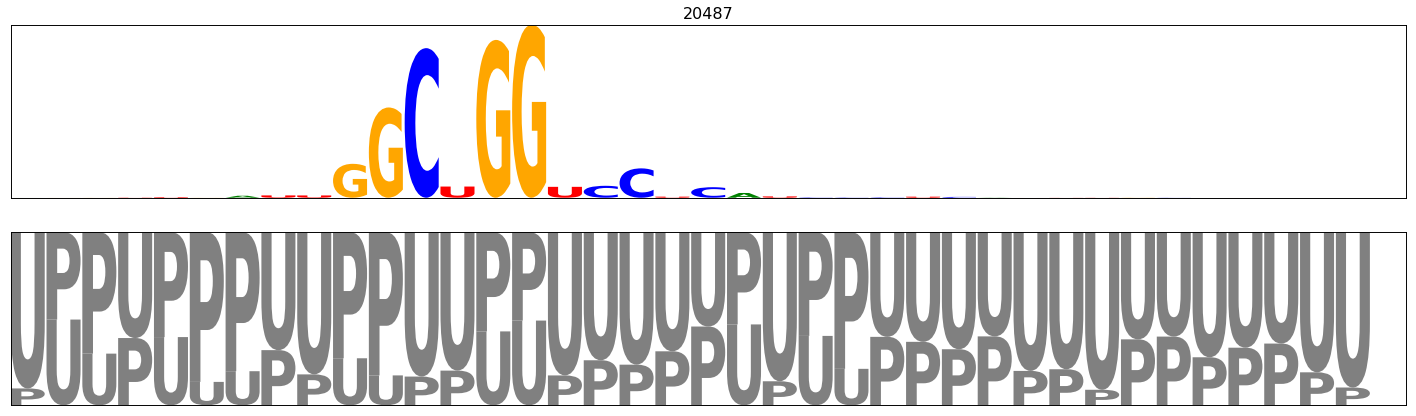

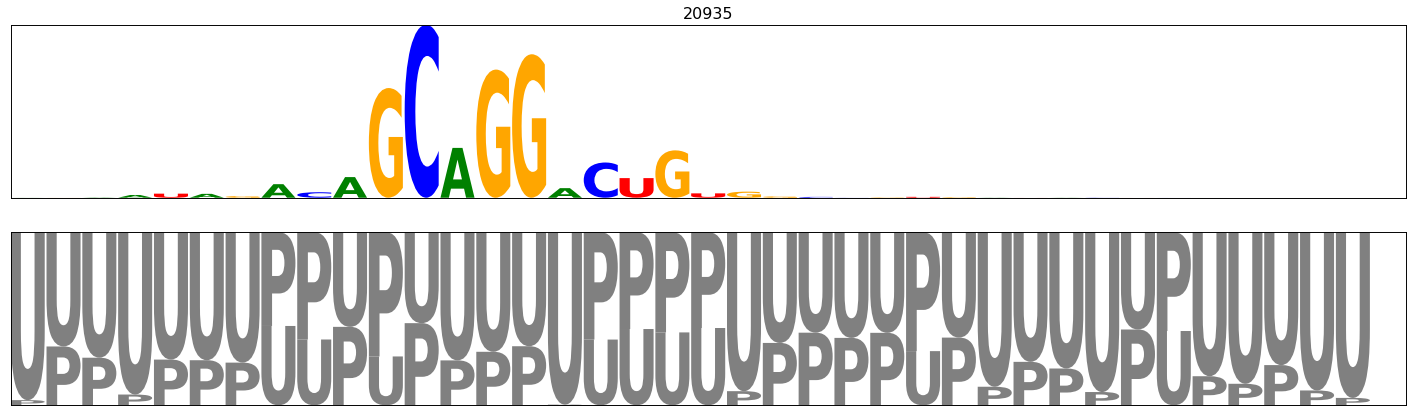

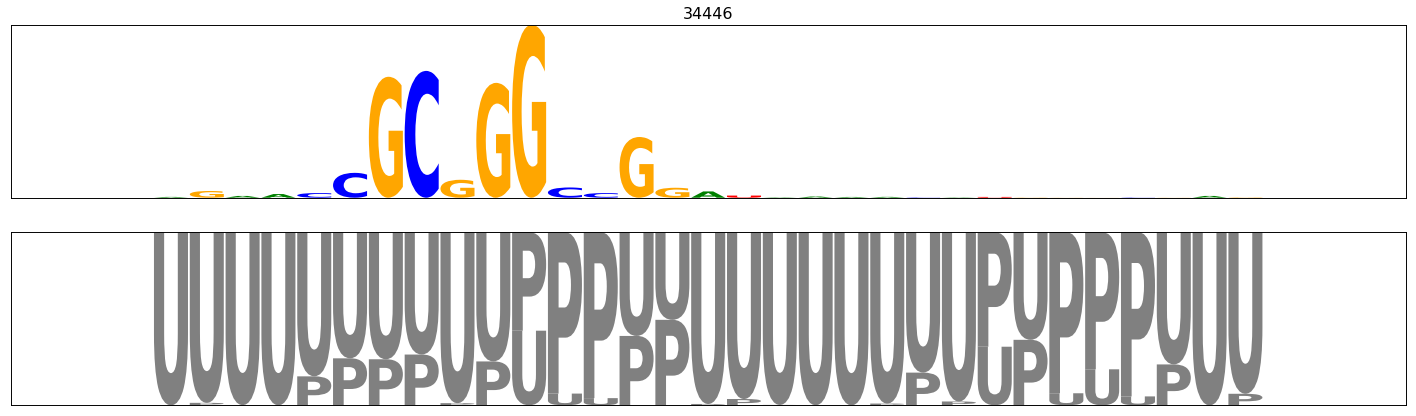

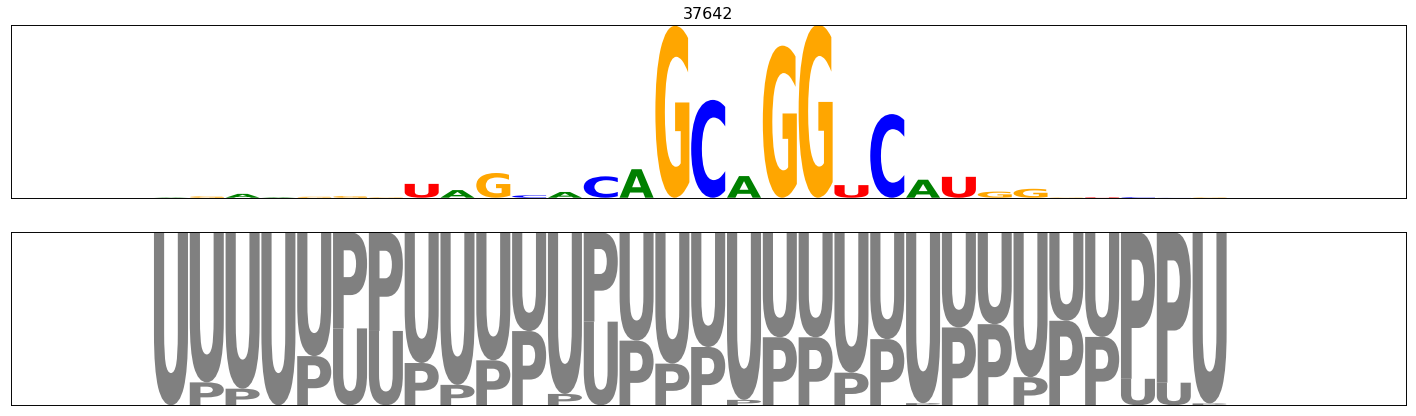

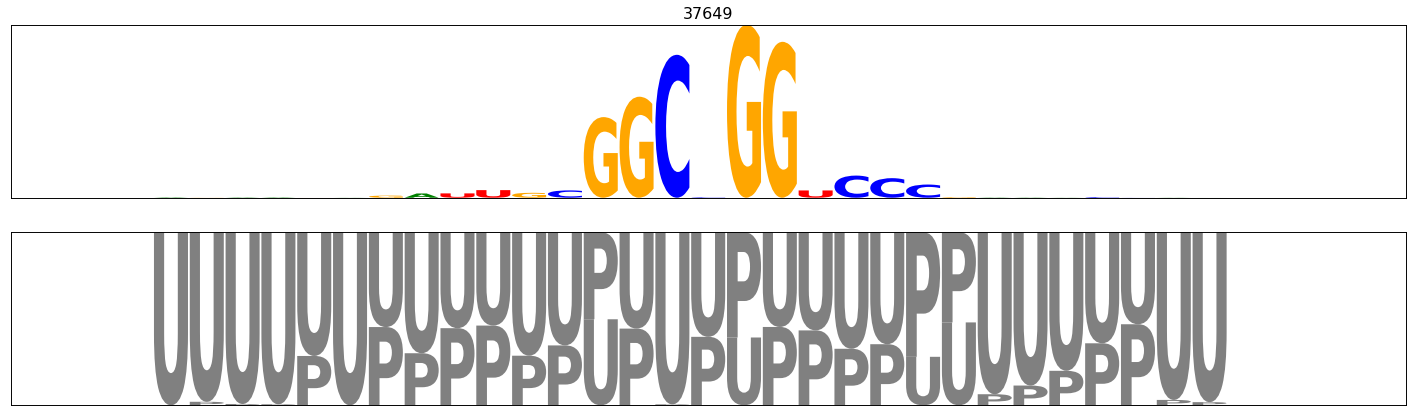

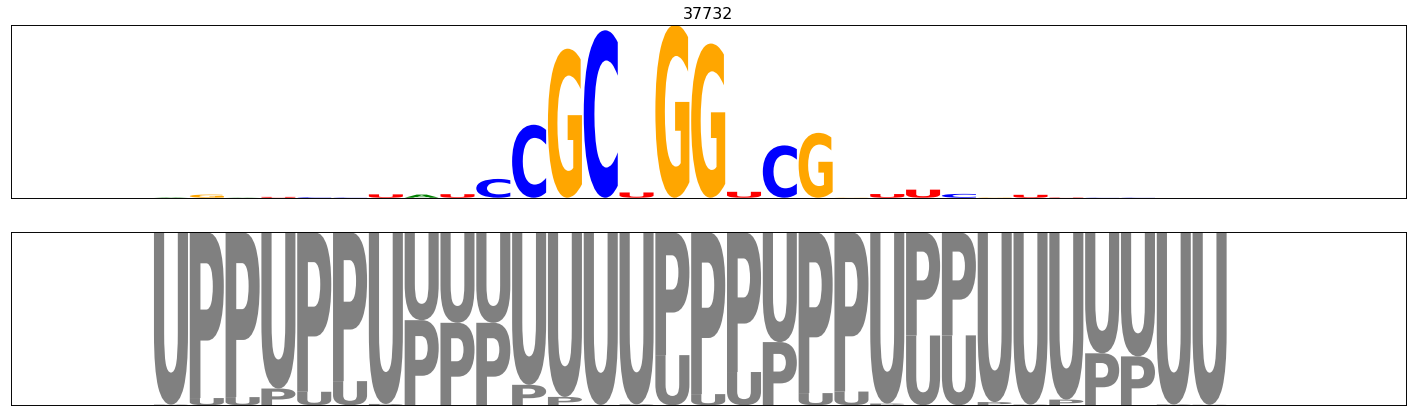

In [25]:
N, L, A = X_high.shape
for k in range(len(X_high)):

    fig = plt.figure(figsize=(25,7))

    
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(4):
        for l in range(L):
            counts_df.iloc[l,a] = attr_map_high[k,l,a]#*X_low[k,l,a]

    ax = plt.subplot(2,1,1)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    plt.title(high_index[k], fontsize=16)
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])
    
    counts_df = pd.DataFrame(data=0.0, columns=list('PU'), index=list(range(L)))
    for a in range(2):
        for l in range(L):
            counts_df.iloc[l,a] = X_high[k,l,a+4]

    ax = plt.subplot(2,1,2)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])

# final plots

In [29]:

low_index = [1007, 1551]
high_index = [478, 821]

In [30]:
rbp_name = 'VTS1'
normalization = 'log_norm'   # 'log_norm' or 'clip_norm'
save_path = helper.make_directory(results_path, normalization+'_'+ss_type)

# load rbp dataset
train, valid, test = helper.load_rnacompete_data(data_path, 
                                                 ss_type='seq', 
                                                 normalization=normalization, 
                                                 dataset_name=rbp_name)
# load rbp dataset
train_pu, valid_pu, test_pu = helper.load_rnacompete_data(data_path, 
                                                         ss_type='pu', 
                                                         normalization=normalization, 
                                                         dataset_name=rbp_name)

# load residualbind model
input_shape = list(train['inputs'].shape)[1:]
weights_path = os.path.join(save_path, rbp_name + '_weights.hdf5')    
model = ResidualBind(input_shape, weights_path)

# load pretrained weights
model.load_weights()

X_high = test_pu['inputs'][high_index]
attr_map_high = explain.mutagenesis(model.model, X_high[:,:,:4], class_index=0, layer=-1)
attr_map_high = np.sum(attr_map_high[:,:,:4]**2, axis=2, keepdims=True)*X_high[:,:,:4]

X_low = test_pu['inputs'][low_index[:75]]
attr_map_low = explain.mutagenesis(model.model, X_low[:,:,:4], class_index=0, layer=-1)
attr_map_low = np.sum(attr_map_low[:,:,:4]**2, axis=2, keepdims=True)*X_low[:,:,:4]


  Loading model from: ../results_final/rnacompete_2009/log_norm_seq/VTS1_weights.hdf5


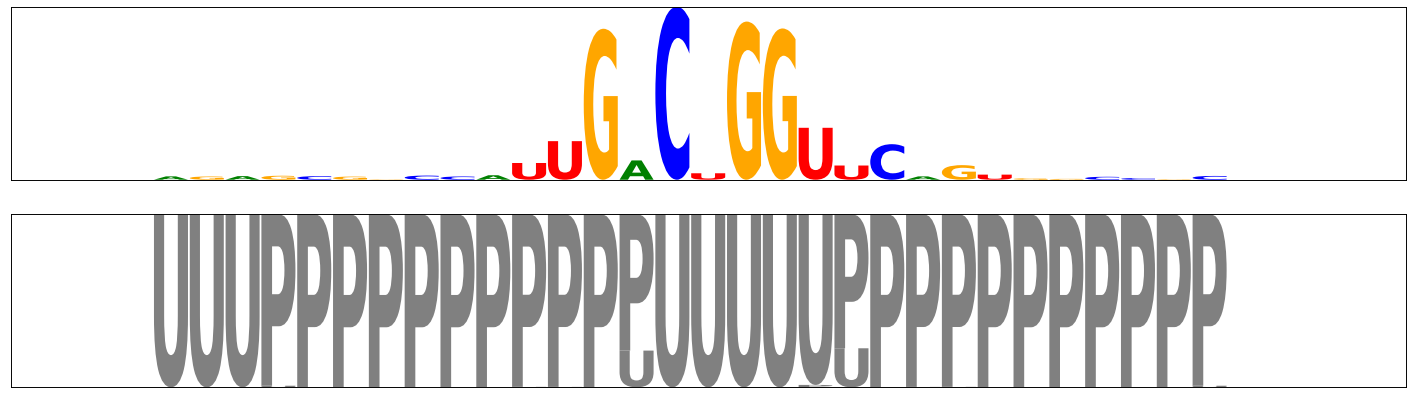

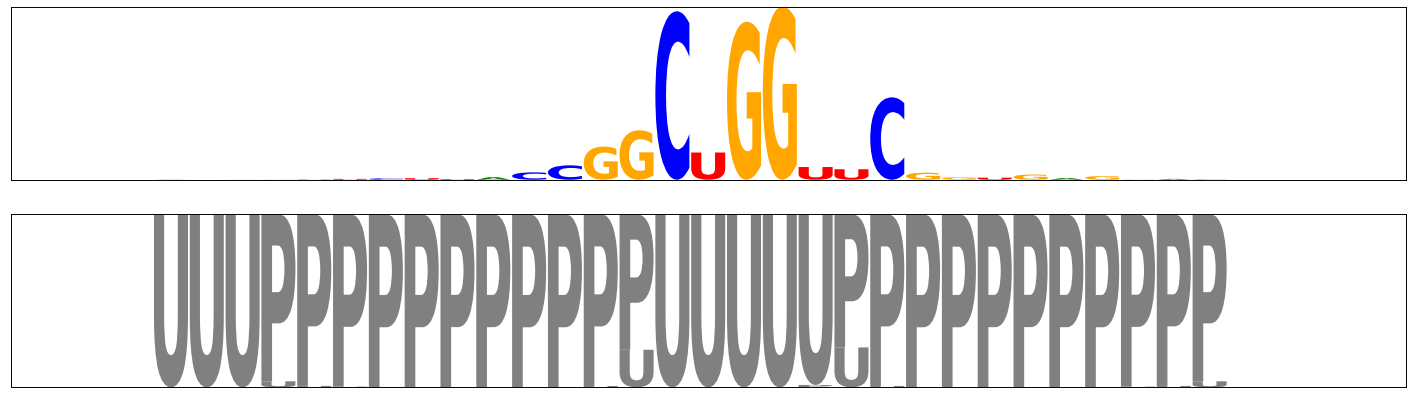

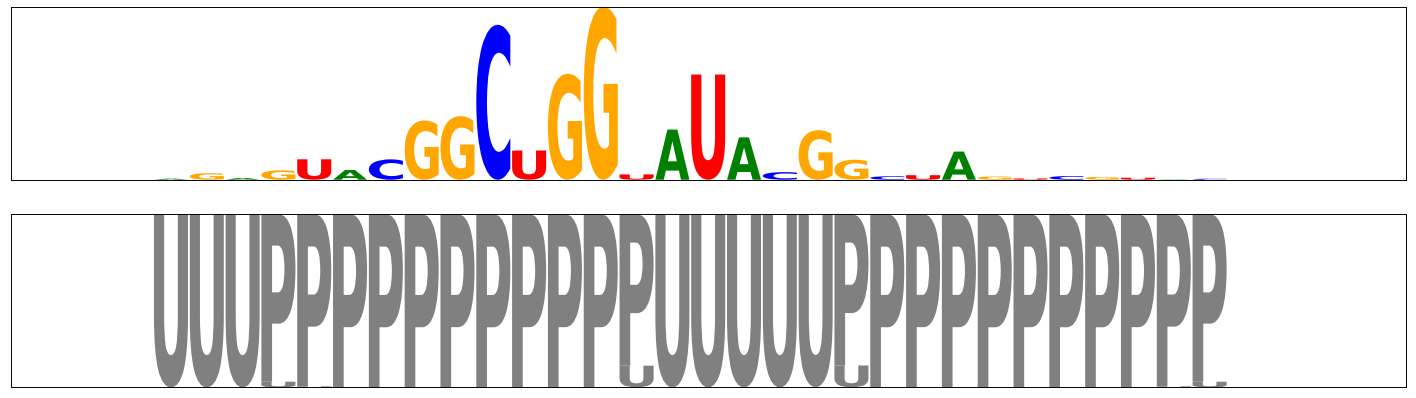

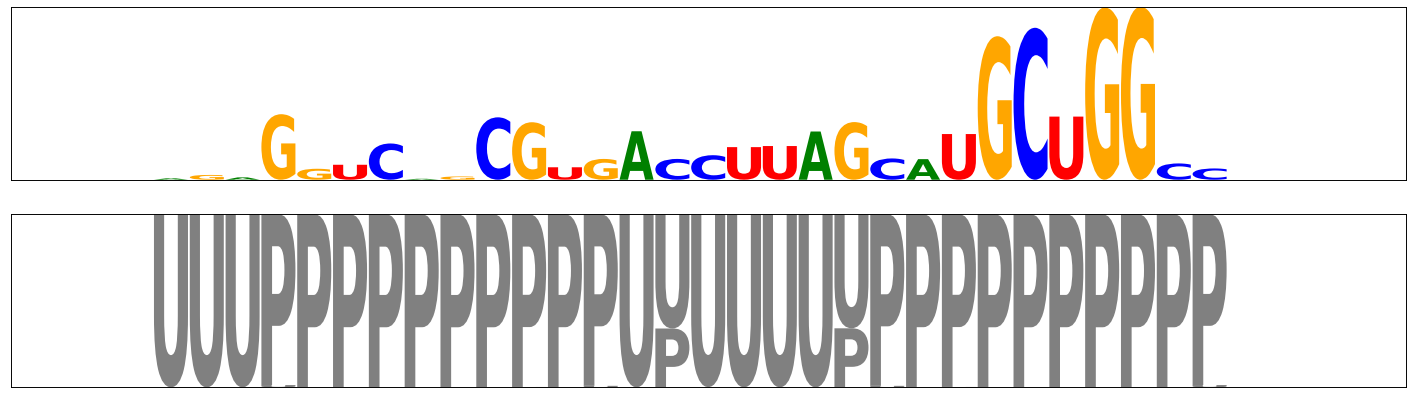

In [33]:
N, L, A = X_high.shape
for k in range(len(X_high)):

    fig = plt.figure(figsize=(25,7))

    
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(4):
        for l in range(L):
            counts_df.iloc[l,a] = attr_map_high[k,l,a]#*X_low[k,l,a]

    ax = plt.subplot(2,1,1)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    ax2 = ax.twinx()
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])
    
    counts_df = pd.DataFrame(data=0.0, columns=list('PU'), index=list(range(L)))
    for a in range(2):
        for l in range(L):
            counts_df.iloc[l,a] = X_high[k,l,a+4]

    ax = plt.subplot(2,1,2)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])

    outfile = os.path.join(plot_path, str(high_index[k])+'_vts1_scatter.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    
N, L, A = X_low.shape
for k in range(len(X_low)):

    fig = plt.figure(figsize=(25,7))

    
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(4):
        for l in range(L):
            counts_df.iloc[l,a] = attr_map_low[k,l,a]#*X_low[k,l,a]

    ax = plt.subplot(2,1,1)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    ax2 = ax.twinx()
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])
    
    counts_df = pd.DataFrame(data=0.0, columns=list('PU'), index=list(range(L)))
    for a in range(2):
        for l in range(L):
            counts_df.iloc[l,a] = X_low[k,l,a+4]

    ax = plt.subplot(2,1,2)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])

    outfile = os.path.join(plot_path, str(low_index[k])+'_vts1_scatter.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    

# Scatter plot

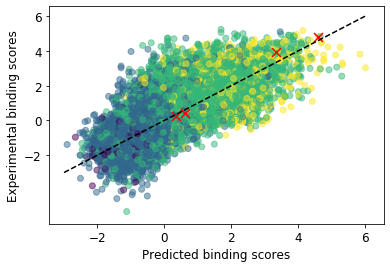

In [5]:

index = [1007, 1551, 478, 821]

fig = plt.figure()
plt.plot([-3,6], [-3,6], '--k')
plt.scatter(predictions[:,0], test['targets'][:,0], c=max_scan, cmap='viridis', alpha=0.5, rasterized=True)
plt.scatter(predictions[index,0], test['targets'][index,0], marker='x', c='r', s=80)
plt.xlabel('Predicted binding scores', fontsize=12)
plt.ylabel('Experimental binding scores', fontsize=12)
plt.xticks([-2, 0, 2, 4, 6], fontsize=12)
plt.yticks([-2, 0, 2, 4, 6], fontsize=12)
outfile = os.path.join(plot_path, 'vts1_scatter.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

In [18]:
test['targets'][:100,0].shape

(100,)

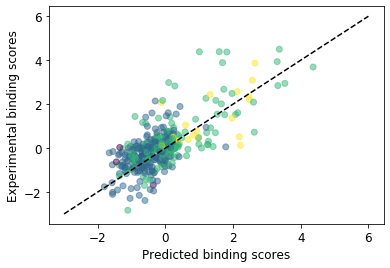

In [22]:

index = [1007, 1551, 478, 821]
fig = plt.figure()
plt.plot([-3,6], [-3,6], '--k')
plt.scatter(predictions[::100,0], test['targets'][::100,0], c=max_scan[::100], cmap='viridis', alpha=0.5)
plt.xlabel('Predicted binding scores', fontsize=12)
plt.ylabel('Experimental binding scores', fontsize=12)
plt.xticks([-2, 0, 2, 4, 6], fontsize=12)
plt.yticks([-2, 0, 2, 4, 6], fontsize=12)
outfile = os.path.join(plot_path, 'vts1_scatter_hires.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# Global importance analysis 

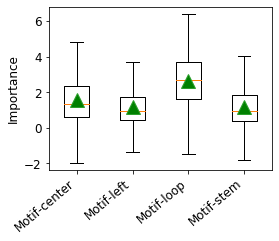

In [10]:

from scipy import stats
from residualbind import GlobalImportance
import helper

alphabet = 'ACGU'
motif = 'GCUGG'

# instantiate global importance
gi = GlobalImportance(model, alphabet)

# set null sequence model
null_seq_model = np.mean(np.squeeze(train['inputs']), axis=0)
null_seq_model /= np.sum(null_seq_model, axis=1, keepdims=True)
gi.set_null_model(null_seq_model, num_sim=1000)


positions = [17, 9]

# embed patterns in same positions in random sequences
all_scores = []
for position in positions:
    all_scores.append(gi.embed_predict_effect((motif, position), class_index=0))

# embed motif in loop and stem of hairpin sequence
for position in positions:
    one_hot = gi.embed_pattern_hairpin((motif, position), stem_left=8, stem_right=24, stem_size=9)
    all_scores.append(gi.predict_effect(one_hot))
all_scores = np.array(all_scores)

fig = plt.figure(figsize=(4,3))
flierprops = dict(marker='^', markerfacecolor='green', markersize=14, linestyle='none')
box = plt.boxplot(all_scores.T, showfliers=False, showmeans=True, meanprops=flierprops);
plt.xticks([1, 2, 3, 4], [ 'Motif-center', 'Motif-left', 'Motif-loop', 'Motif-stem'], rotation=40, fontsize=12, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=12);
plt.ylabel('Importance', fontsize=12)


outfile = '../results_final/rnacompete_2009/vts1_hairpin_analysis_new.pdf'
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')